<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: spec2, barshadow step

<span style="color:red"> **Instruments Affected**</span>: NIRSpec 

Tested on CV3 data

### Table of Contents
<div style="text-align: left"> 

<br> [Imports](#imports_ID) <br> [Introduction](#intro_ID) <br> [Testing Data Set](#data_ID) <br> [Run the JWST pipeline and assign_wcs validation tests](#pipeline_ID): [FS Full-Frame test](#FULLFRAME), [FS ALLSLITS test](#ALLSLITS), [MOS test](#MOS) <br> [About This Notebook](#about_ID)<br> [Results](#results) <br>

</div>

<a id="imports_ID"></a>
# Imports
The library imports relevant to this notebook are aready taken care of by importing PTT.

* astropy.io for opening fits files
* jwst.module.PipelineStep is the pipeline step being tested
* matplotlib.pyplot.plt to generate plot

NOTE: This notebook assumes that the pipeline version to be tested is already installed and its environment is activated.

To be able to run this notebook you need to install nptt. 

If all goes well you will be able to import PTT.

[Top of Page](#title_ID)

In [1]:
import os
import psutil
import subprocess
from glob import glob

import jwst
from jwst.pipeline.calwebb_detector1 import Detector1Pipeline
from jwst.assign_wcs.assign_wcs_step import AssignWcsStep
from jwst.msaflagopen.msaflagopen_step import MSAFlagOpenStep
from jwst.extract_2d.extract_2d_step import Extract2dStep
from jwst.srctype.srctype_step import SourceTypeStep
from jwst.flatfield.flat_field_step import FlatFieldStep
from jwst.pathloss.pathloss_step import PathLossStep
from jwst.barshadow import BarShadowStep
from jwst import datamodels

# The latest version of NPTT is installed in the requirements text file at:
# /jwst_validation_notebooks/environment.yml

# import NPTT
import nirspec_pipe_testing_tool as nptt

# To get data from Artifactory
from ci_watson.artifactory_helpers import get_bigdata


In [2]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import shutil
data_dir = TemporaryDirectory()

# If you have files that are in the notebook's directory, but that the notebook will need to use while
# running, copy them into the temporary directory here.
#
# files = ['name_of_file']
# for file_name in files:
#     shutil.copy(file_name, os.path.join(data_dir.name, file_name))

os.chdir(data_dir.name)

In [3]:
# Make sure that the version used is the right one

pipeline_version = jwst.__version__
nptt_version = nptt.__version__

print("Using jwst pipeline version: ", pipeline_version)
print("Using NPTT version: ", nptt_version)

Using jwst pipeline version:  0.18.3
Using NPTT version:  1.1.6.dev0+g47147b2.d20210219


<a id="intro_ID"></a>
# Test Description

The NIRSpec team implemented code for the barshadow step and then compared the output with the the pipeline. The test is considered passed if the difference between the two outputs is smaller than 5%, the error provided by the IDT team (or 0.0025 in absolute numbers). 

For the test to be considered PASSED, every single MOS slitlet has to pass. If there is any failure, the whole test will be considered as FAILED. 

The code for this test can be obtained from: https://github.com/spacetelescope/nirspec_pipe_testing_tool/blob/master/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/barshadow_testing.py. 


Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/barshadow/description.html

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/barshadow


### Results

If the test **PASSED** this means that all slits, slitlets, or slices individually passed the test. However, if ony one individual MOS slitlet, the whole test will be reported as **FAILED**.


### Calibration WG Requested Algorithm: 

A short description and link to the page: https://outerspace.stsci.edu/pages/viewpage.action?spaceKey=JWSTCC&title=Vanilla+MSA+Bar+Shadow+Correction


### Defining Term
Acronymns used un this notebook:

pipeline: calibration pipeline

spec2: spectroscopic calibration pipeline level 2b

PTT: NIRSpec pipeline testing tool (https://github.com/spacetelescope/nirspec_pipe_testing_tool)


[Top of Page](#title_ID)

<a id="pipeline_ID"></a>
# Run the JWST pipeline and pathloss validation tests

The pipeline can be run from the command line in two variants: full or per step.

Tu run the spec2 pipeline in full use the command: 

$ strun jwst.pipeline.Spec2Pipeline jwtest_rate.fits

Tu only run the barshadow step, use the command:

$ strun jwst.barshadow.BarShadowStep jwtest_previous_step_output.fits


These options are also callable from a script with the testing environment active. The Python call for running the pipeline in full or by step are:

$\gt$ from jwst.pipeline.calwebb_spec2 import Spec2Pipeline

$\gt$ Spec2Pipeline.call(jwtest_rate.fits)
 
or
 
$\gt$ from jwst.barshadow import BarShadowStep
 
$\gt$ BarShadowStep.call(jwtest_previous_step_output.fits)


PTT can run the spec2 pipeline either in full or per step, as well as the imaging pipeline in full. In this notebook we will use PTT to run the pipeline and the validation tests. To run PTT, follow the directions in the corresponding repo page.

[Top of Page](#title_ID)

<a id="data_ID"></a>
# Testing Data Set

All testing data is from the CV3 campaign. We chose these files because this is our most complete data set, i.e. all modes and filter-grating combinations.

Data used was for testing was only MOS:
- MOS_G140M_LINE1 
- MOS_PRISM


[Top of Page](#title_ID)

In [4]:
testing_data = {              
                'mos_prism_clear':{
                                  'uncal_file_nrs1': 'mos_prism_nrs1_uncal.fits',
                                  'uncal_file_nrs2': 'mos_prism_nrs2_uncal.fits',
                                  'msa_shutter_config': 'V0030006000104_msa.fits' },
                
                'mos_g140m_f100lp':{
                                  'uncal_file_nrs1': 'mos_g140m_line1_NRS1_uncal.fits',
                                  'uncal_file_nrs2': 'mos_g140m_line1_NRS2_uncal.fits',  
                                  'msa_shutter_config': 'V8460001000101_msa.fits' }
                }

In [5]:
# define function to pull data from Artifactory
def get_artifactory_file(data_set_dict, detector):
    """This function creates a list with all the files needed per detector to run the test.
    Args:
        data_set_dict: dictionary, contains inputs for a specific mode and configuration
        detector: string, either nrs1 or nrs2
    Returns:
        data: list, contains all files needed to run test
    """
    files2obtain = ['uncal_file_nrs1', 'msa_shutter_config']
    data = []
    for file in files2obtain:
        data_file = None
        try: 
            if '_nrs' in file and '2' in detector:
                file = file.replace('_nrs1', '_nrs2')

            data_file = get_bigdata('jwst_validation_notebooks',
                                         'validation_data',
                                         'nirspec_data', 
                                         data_set_dict[file])
        except TypeError:
            data.append(None)
            continue

        data.append(data_file)

    return data
    

2021-02-20 01:37:14,782 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Testing files for detector:  nrs1
Working with uncal_file:  /private/var/folders/62/jxd06t_15f5_4zsxs5zrgdfm0004vc/T/tmptf_e3mkh/mos_prism_nrs1_uncal.fits


2021-02-20 01:37:26,924 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2021-02-20 01:37:26,925 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2021-02-20 01:37:26,926 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2021-02-20 01:37:26,928 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2021-02-20 01:37:26,929 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2021-02-20 01:37:26,930 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2021-02-20 01:37:26,931 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2021-02-20 01:37:26,933 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2021-02-20 01:37:26,934 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2021-02-20 01:37:26,935 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2021-02-20 0

2021-02-20 01:37:27,805 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0018.fits'.
2021-02-20 01:37:27,806 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0022.fits'.
2021-02-20 01:37:27,806 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.
2021-02-20 01:37:27,807 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.
2021-02-20 01:37:27,807 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0020.fits'.
2021-02-20 01:37:27,808 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0113.fits'.
2021-02-20 01:37:27,809 - stpipe.Detector1Pipeline - INFO - P

2021-02-20 01:37:30,306 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done
2021-02-20 01:37:30,418 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs1_uncal.fits>,).
2021-02-20 01:37:30,419 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/private/var/folders/62/jxd06t_15f5_4zsxs5zrgdfm0004vc/T/tmptf_e3mkh', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}
2021-02-20 01:37:30,434 - stpipe.Detector1Pipeline.refpix - INFO - Using refpix reference file: /Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0022.fits
2021-02-20 01:37:30,820 - stpipe.De

2021-02-20 01:37:56,089 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/utils.py:534: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pix_not_done = np.ones( npix, dtype=np.bool)  # initialize to True

2021-02-20 01:37:57,082 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 4
2021-02-20 01:37:57,083 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 1
2021-02-20 01:37:57,090 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_

2021-02-20 01:37:58,451 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs
2021-02-20 01:37:58,454 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done
2021-02-20 01:37:58,468 - stpipe.MSAFlagOpenStep - INFO - MSAFlagOpenStep instance created.
2021-02-20 01:37:58,585 - stpipe.MSAFlagOpenStep - INFO - Step MSAFlagOpenStep running with args (<ImageModel(2048, 2048) from mos_prism_nrs1_uncal.fits>,).
2021-02-20 01:37:58,587 - stpipe.MSAFlagOpenStep - INFO - Step MSAFlagOpenStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2021-02-20 01:37:58,600 - stpipe.MSAFlagOpenStep - INFO - Using reference file /Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0001.json
2021-02-20 01:37:58,602 - stpipe.Step - INFO - Step instance created.
2021-02-20 01:37:58,

2021-02-20 01:38:20,014 - stpipe.PathLossStep - INFO - Step PathLossStep done
2021-02-20 01:38:20,032 - stpipe.BarShadowStep - INFO - BarShadowStep instance created.
2021-02-20 01:38:20,144 - stpipe.BarShadowStep - INFO - Step BarShadowStep running with args (<MultiSlitModel from mos_prism_nrs1_uncal.fits>,).
2021-02-20 01:38:20,146 - stpipe.BarShadowStep - INFO - Step BarShadowStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}
2021-02-20 01:38:20,165 - stpipe.BarShadowStep - INFO - Using BARSHADOW reference file /Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_barshadow_0001.fits
2021-02-20 01:38:20,499 - stpipe.BarShadowStep - INFO - Working on slitlet 3
2021-02-20 01:38:20,507 - stpipe.BarShadowStep - INFO - Bar sha

Looping over open slitlets...
Working with slitlet  3
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Did barshadow validation test passed?  The test is skipped for POINT sources, since the correction is not applied 


Testing files for detector:  nrs2
Working with uncal_file:  /private/var/folders/62/jxd06t_15f5_4zsxs5zrgdfm0004vc/T/tmptf_e3mkh/mos_prism_nrs2_uncal.fits


2021-02-20 01:38:29,688 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2021-02-20 01:38:29,689 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2021-02-20 01:38:29,691 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2021-02-20 01:38:29,692 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2021-02-20 01:38:29,694 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2021-02-20 01:38:29,695 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2021-02-20 01:38:29,696 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2021-02-20 01:38:29,698 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2021-02-20 01:38:29,699 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2021-02-20 01:38:29,701 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2021-02-20 0

2021-02-20 01:38:30,003 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0017.fits'.
2021-02-20 01:38:30,003 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0020.fits'.
2021-02-20 01:38:30,004 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.
2021-02-20 01:38:30,004 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.
2021-02-20 01:38:30,005 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0021.fits'.
2021-02-20 01:38:30,005 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0114.fits'.
2021-02-20 01:38:30,006 - stpipe.Detector1Pipeline - INFO - P

2021-02-20 01:38:32,448 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done
2021-02-20 01:38:32,555 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs2_uncal.fits>,).
2021-02-20 01:38:32,556 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/private/var/folders/62/jxd06t_15f5_4zsxs5zrgdfm0004vc/T/tmptf_e3mkh', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}
2021-02-20 01:38:32,570 - stpipe.Detector1Pipeline.refpix - INFO - Using refpix reference file: /Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0020.fits
2021-02-20 01:38:32,964 - stpipe.De

2021-02-20 01:38:59,243 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/utils.py:534: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pix_not_done = np.ones( npix, dtype=np.bool)  # initialize to True

2021-02-20 01:39:00,251 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 4
2021-02-20 01:39:00,251 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 1
2021-02-20 01:39:00,259 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_

No open slits fall on detector  nrs2 

Testing files for detector:  nrs1
Working with uncal_file:  /private/var/folders/62/jxd06t_15f5_4zsxs5zrgdfm0004vc/T/tmptf_e3mkh/mos_g140m_line1_NRS1_uncal.fits


2021-02-20 01:39:09,535 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2021-02-20 01:39:09,536 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2021-02-20 01:39:09,537 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2021-02-20 01:39:09,539 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2021-02-20 01:39:09,540 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2021-02-20 01:39:09,541 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2021-02-20 01:39:09,543 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2021-02-20 01:39:09,545 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2021-02-20 01:39:09,546 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2021-02-20 01:39:09,548 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2021-02-20 0

2021-02-20 01:39:09,799 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2021-02-20 01:39:09,800 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0019.fits'.
2021-02-20 01:39:09,800 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2021-02-20 01:39:09,801 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.
2021-02-20 01:39:09,801 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.
2021-02-20 01:39:09,802 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0023.fits'.
2021-02-20 01:39:09,802 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0087.fits'.
2021-02-20 01:39:09,803 - stp

2021-02-20 01:39:15,318 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0140.fits
2021-02-20 01:39:15,618 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=6, nframes=1, groupgap=0
2021-02-20 01:39:15,618 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=10, nframes=1, groupgap=0
2021-02-20 01:39:15,736 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2021-02-20 01:39:15,872 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS1_uncal.fits>,).
2021-02-20 01:39:15,873 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output

2021-02-20 01:39:41,242 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 6
2021-02-20 01:39:41,242 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 1
2021-02-20 01:39:41,371 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done
2021-02-20 01:39:41,516 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(2048, 2048) from mos_g140m_line1_NRS1_uncal.fits>,).
2021-02-20 01:39:41,517 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/private/var/folders/62/jxd06t_15f5_4zsxs5zrgdfm0004vc/T/tmptf_e3mkh'}
2021-02-20 01:39:41,561 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference fi

2021-02-20 01:39:42,875 - stpipe.AssignWcsStep - INFO - Removing slit 1 from the list of open slits because the WCS bounding_box is completely outside the detector.
2021-02-20 01:39:42,893 - stpipe.AssignWcsStep - INFO - Removing slit 2 from the list of open slits because the WCS bounding_box is completely outside the detector.
2021-02-20 01:39:42,910 - stpipe.AssignWcsStep - INFO - Removing slit 3 from the list of open slits because the WCS bounding_box is completely outside the detector.
2021-02-20 01:39:42,927 - stpipe.AssignWcsStep - INFO - Removing slit 4 from the list of open slits because the WCS bounding_box is completely outside the detector.
2021-02-20 01:39:42,944 - stpipe.AssignWcsStep - INFO - Removing slit 5 from the list of open slits because the WCS bounding_box is completely outside the detector.
2021-02-20 01:39:42,963 - stpipe.AssignWcsStep - INFO - Removing slit 12 from the list of open slits because the WCS bounding_box is completely outside the detector.
2021-02-2

2021-02-20 01:39:58,803 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 53
2021-02-20 01:39:58,803 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1542 2048
2021-02-20 01:39:58,804 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1315 1329
2021-02-20 01:39:58,935 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2021-02-20 01:39:58,945 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.226123221 -45.673642180 156.225994086 -45.673519691 156.225931834 -45.673551545 156.226060967 -45.673674035
2021-02-20 01:39:58,946 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.226123221 -45.673642180 156.225994086 -45.673519691 156.225931834 -45.673551545 156.226060967 -45.673674035
2021-02-20 01:39:59,642 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 54
2021-02-20 01:39:59,643 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1542 2048
2021-02-20 01:39:59,643 - stpipe.Extract2dStep - INFO - Subarray y-

2021-02-20 01:40:07,563 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 51
2021-02-20 01:40:07,564 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1759 2048
2021-02-20 01:40:07,564 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 430 445
2021-02-20 01:40:07,690 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2021-02-20 01:40:07,700 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.212403238 -45.648718689 156.212275928 -45.648598111 156.212213993 -45.648629742 156.212341301 -45.648750320
2021-02-20 01:40:07,700 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.212403238 -45.648718689 156.212275928 -45.648598111 156.212213993 -45.648629742 156.212341301 -45.648750320
2021-02-20 01:40:08,236 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 52
2021-02-20 01:40:08,236 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1722 2048
2021-02-20 01:40:08,237 - stpipe.Extract2dStep - INFO - Subarray y-ex

2021-02-20 01:40:16,373 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 61
2021-02-20 01:40:16,373 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 620 2048
2021-02-20 01:40:16,374 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 822 840
2021-02-20 01:40:16,503 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2021-02-20 01:40:16,512 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.184095390 -45.677365774 156.183968526 -45.677243686 156.183906587 -45.677275659 156.184033450 -45.677397747
2021-02-20 01:40:16,512 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.184095390 -45.677365774 156.183968526 -45.677243686 156.183906587 -45.677275659 156.184033450 -45.677397747
2021-02-20 01:40:17,037 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 62
2021-02-20 01:40:17,038 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 570 2032
2021-02-20 01:40:17,038 - stpipe.Extract2dStep - INFO - Subarray y-exte

2021-02-20 01:40:32,358 - stpipe.FlatFieldStep - INFO - Working on slit 42
2021-02-20 01:40:32,476 - stpipe.FlatFieldStep - INFO - Working on slit 43
2021-02-20 01:40:32,646 - stpipe.FlatFieldStep - INFO - Working on slit 44
2021-02-20 01:40:32,815 - stpipe.FlatFieldStep - INFO - Working on slit 45
2021-02-20 01:40:33,055 - stpipe.FlatFieldStep - INFO - Working on slit 46
2021-02-20 01:40:33,363 - stpipe.FlatFieldStep - INFO - Working on slit 47
2021-02-20 01:40:33,753 - stpipe.FlatFieldStep - INFO - Working on slit 48
2021-02-20 01:40:34,145 - stpipe.FlatFieldStep - INFO - Working on slit 49
2021-02-20 01:40:34,598 - stpipe.FlatFieldStep - INFO - Working on slit 50
2021-02-20 01:40:35,012 - stpipe.FlatFieldStep - INFO - Working on slit 51
2021-02-20 01:40:35,426 - stpipe.FlatFieldStep - INFO - Working on slit 52
2021-02-20 01:40:35,888 - stpipe.FlatFieldStep - INFO - Working on slit 55
2021-02-20 01:40:37,188 - stpipe.FlatFieldStep - INFO - Working on slit 65
2021-02-20 01:40:39,138 -

Looping over open slitlets...
Working with slitlet  53
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibrations/5.3_BarShadow/referenceFilesBS-20160401/jwst-nirspec-mos1x1.bsrf.fits
Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


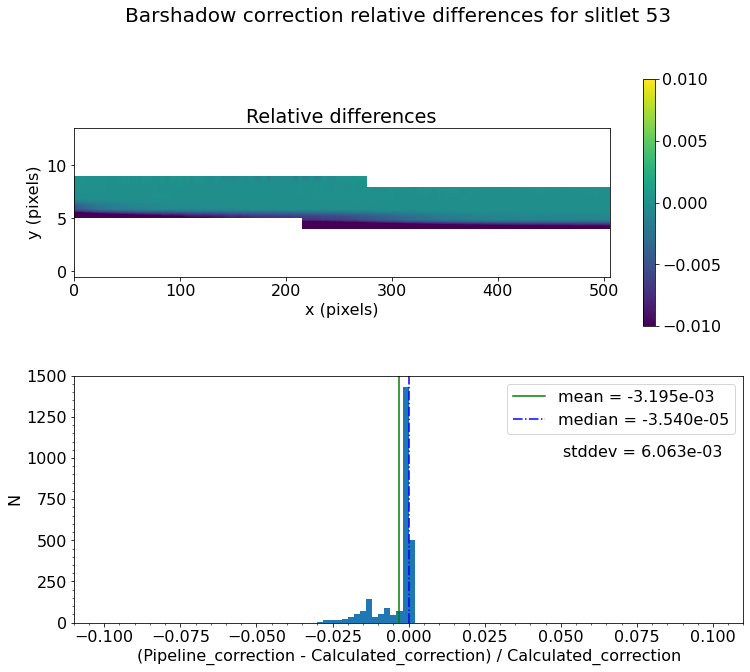

2021-02-20 01:41:16,248 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:41:16,248 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(

2021-02-20 01:41:16,329 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:41:16,330 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(




   Relative barshadow_correction  :   mean = -3.195e-03    median = -3.540e-05    stdev = 6.063e-03
    Maximum   Relativebarshadow_correction = 5.761e-04
    Minimum   Relativebarshadow_correction = -2.816e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 13%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 53? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: FAILED

Working with slitlet  54
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Referenc

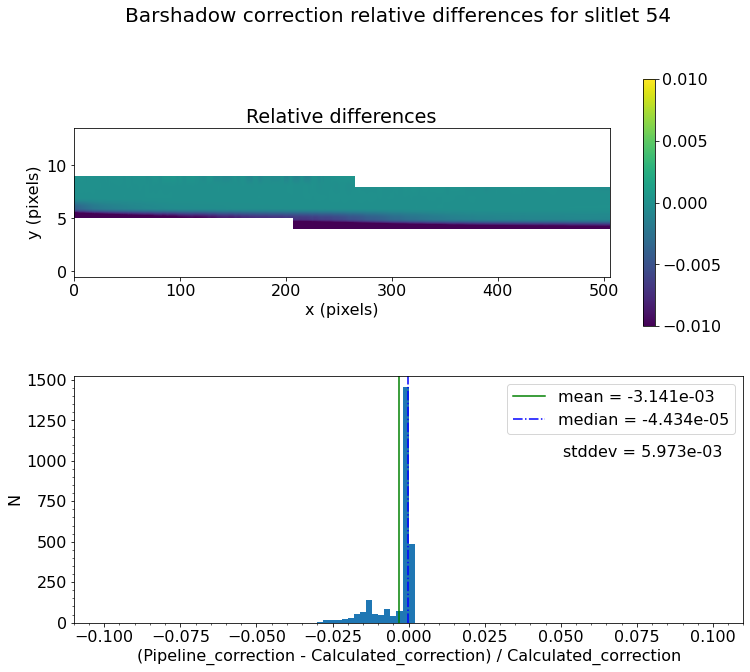

2021-02-20 01:41:18,322 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:41:18,323 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(

2021-02-20 01:41:18,402 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:41:18,402 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(

2021-02-20 01:41:18,403 - stpipe -


   Relative barshadow_correction  :   mean = -3.141e-03    median = -4.434e-05    stdev = 5.973e-03
    Maximum   Relativebarshadow_correction = 4.518e-04
    Minimum   Relativebarshadow_correction = -2.811e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 12%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 54? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: FAILED

Working with slitlet  42
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Referenc

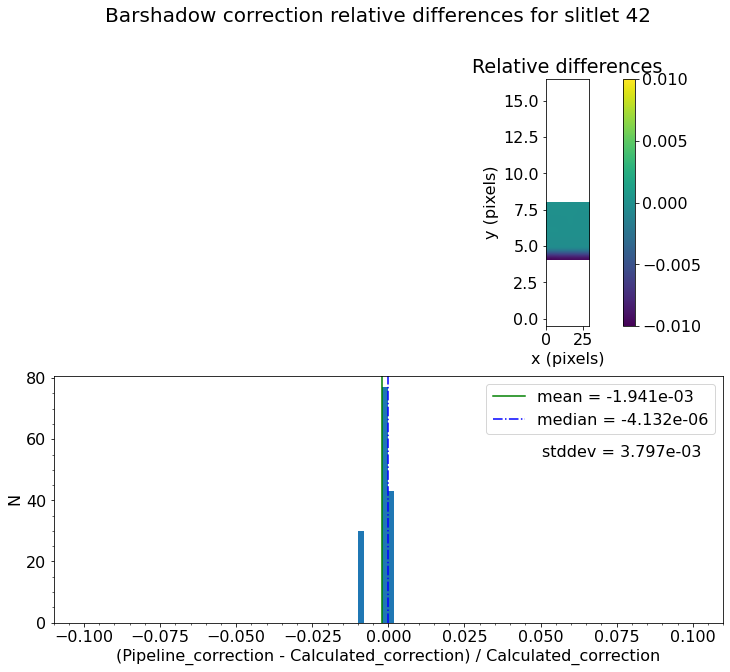

2021-02-20 01:41:20,489 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:41:20,489 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(

2021-02-20 01:41:20,490 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:41:20,491 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(

2021-02-20 01:41:20,570 - stpipe -


   Relative barshadow_correction  :   mean = -1.941e-03    median = -4.132e-06    stdev = 3.797e-03
    Maximum   Relativebarshadow_correction = 1.723e-04
    Minimum   Relativebarshadow_correction = -9.762e-03
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 20%
                            ->  3xtheshold = 20%
                            ->  5xtheshold = 0%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 42? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  43
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

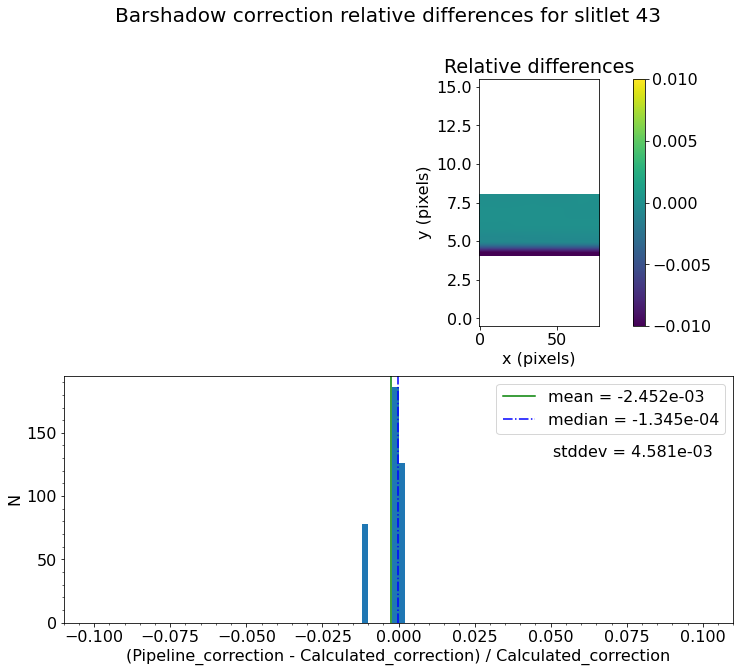

2021-02-20 01:41:22,716 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:41:22,716 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(

2021-02-20 01:41:22,718 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:41:22,718 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(

2021-02-20 01:41:22,796 - stpipe -


   Relative barshadow_correction  :   mean = -2.452e-03    median = -1.345e-04    stdev = 4.581e-03
    Maximum   Relativebarshadow_correction = 2.783e-05
    Minimum   Relativebarshadow_correction = -1.190e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 20%
                            ->  3xtheshold = 20%
                            ->  5xtheshold = 0%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 43? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  44
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

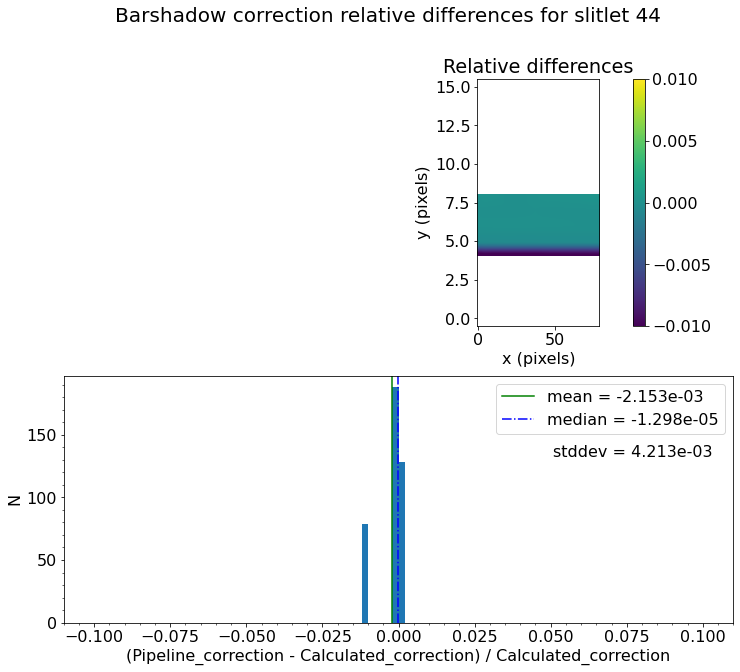

2021-02-20 01:41:24,981 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:41:24,982 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(

2021-02-20 01:41:24,983 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:41:24,984 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(

2021-02-20 01:41:25,063 - stpipe -


   Relative barshadow_correction  :   mean = -2.153e-03    median = -1.298e-05    stdev = 4.213e-03
    Maximum   Relativebarshadow_correction = 3.550e-04
    Minimum   Relativebarshadow_correction = -1.099e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 20%
                            ->  3xtheshold = 20%
                            ->  5xtheshold = 0%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 44? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  45
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

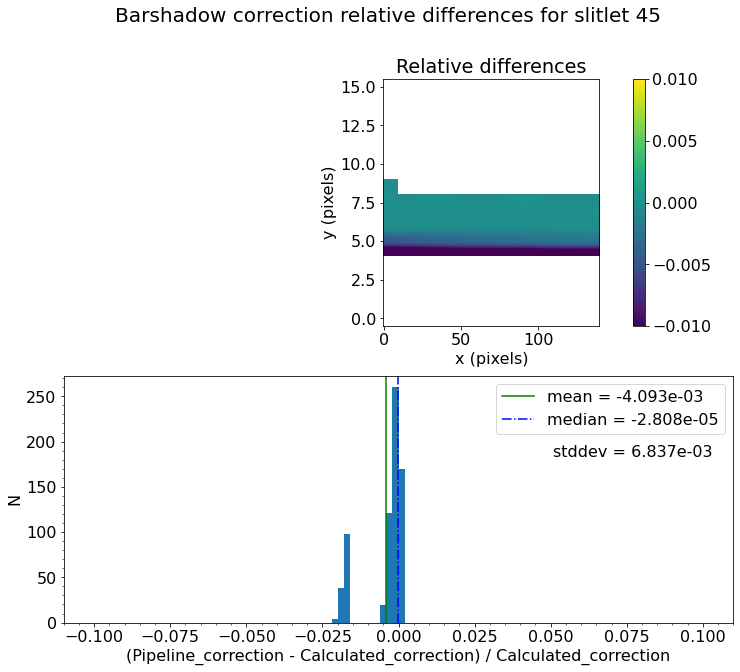

2021-02-20 01:41:27,153 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:41:27,154 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(

2021-02-20 01:41:27,156 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:41:27,157 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(

2021-02-20 01:41:27,243 - stpipe -


   Relative barshadow_correction  :   mean = -4.093e-03    median = -2.808e-05    stdev = 6.837e-03
    Maximum   Relativebarshadow_correction = 2.014e-04
    Minimum   Relativebarshadow_correction = -2.027e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 34%
                            ->  3xtheshold = 20%
                            ->  5xtheshold = 20%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 45? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: FAILED

Working with slitlet  46
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Referenc

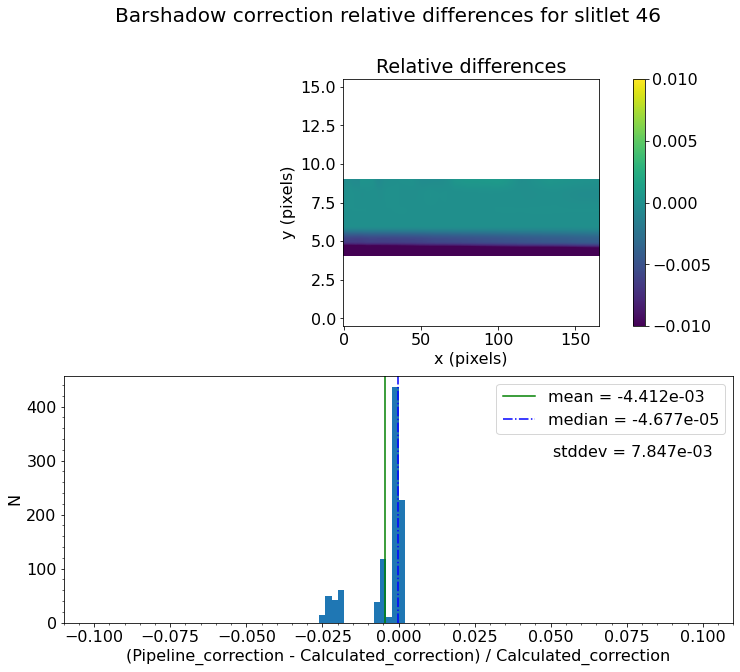

2021-02-20 01:41:29,792 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:41:29,793 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(

2021-02-20 01:41:29,795 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:41:29,795 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(

2021-02-20 01:41:29,875 - stpipe -


   Relative barshadow_correction  :   mean = -4.412e-03    median = -4.677e-05    stdev = 7.847e-03
    Maximum   Relativebarshadow_correction = 8.356e-04
    Minimum   Relativebarshadow_correction = -2.599e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 33%
                            ->  3xtheshold = 17%
                            ->  5xtheshold = 17%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 46? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: FAILED

Working with slitlet  47
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Referenc

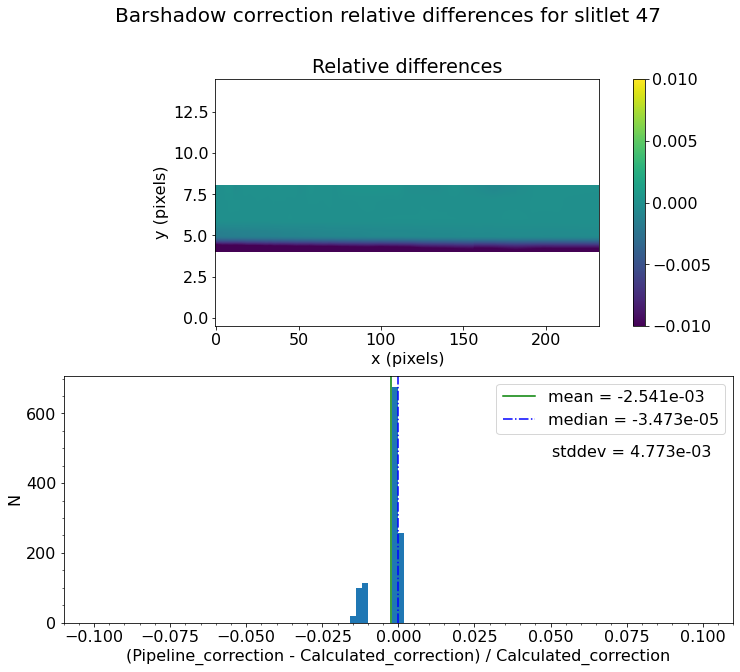

2021-02-20 01:41:32,574 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:41:32,574 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(

2021-02-20 01:41:32,576 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:41:32,577 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(

2021-02-20 01:41:32,657 - stpipe -


   Relative barshadow_correction  :   mean = -2.541e-03    median = -3.473e-05    stdev = 4.773e-03
    Maximum   Relativebarshadow_correction = 3.042e-04
    Minimum   Relativebarshadow_correction = -1.535e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 20%
                            ->  3xtheshold = 20%
                            ->  5xtheshold = 6%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 47? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  48
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

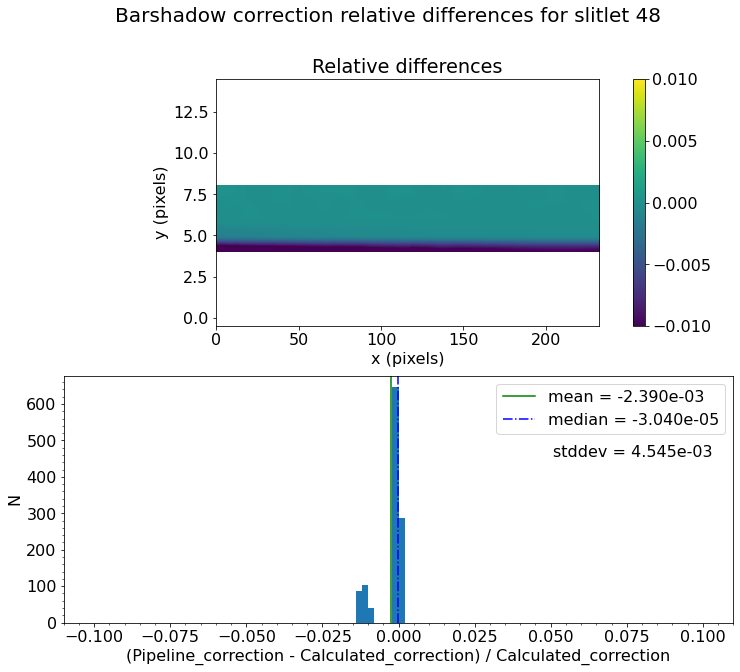

2021-02-20 01:41:34,773 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:41:34,773 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(

2021-02-20 01:41:34,775 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:41:34,775 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(

2021-02-20 01:41:34,854 - stpipe -


   Relative barshadow_correction  :   mean = -2.390e-03    median = -3.040e-05    stdev = 4.545e-03
    Maximum   Relativebarshadow_correction = 3.286e-04
    Minimum   Relativebarshadow_correction = -1.392e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 20%
                            ->  3xtheshold = 20%
                            ->  5xtheshold = 4%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 48? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  49
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

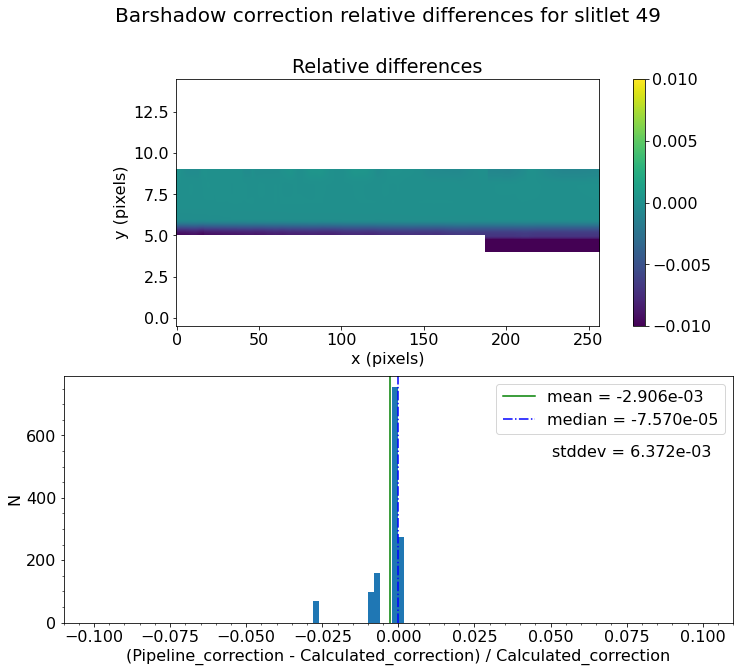

2021-02-20 01:41:36,837 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:41:36,838 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(

2021-02-20 01:41:36,839 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:41:36,840 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(

2021-02-20 01:41:36,922 - stpipe -


   Relative barshadow_correction  :   mean = -2.906e-03    median = -7.570e-05    stdev = 6.372e-03
    Maximum   Relativebarshadow_correction = 4.926e-04
    Minimum   Relativebarshadow_correction = -2.797e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 14%
                            ->  5xtheshold = 5%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 49? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  50
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

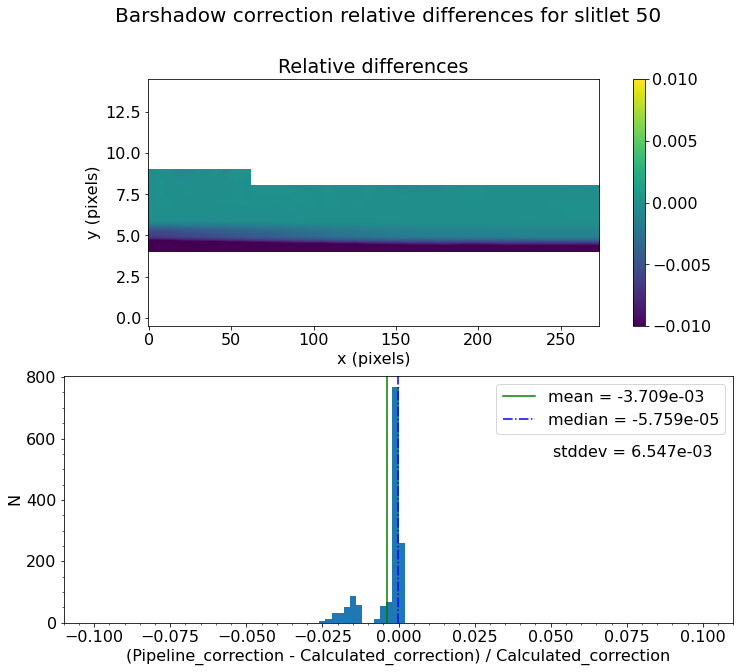

2021-02-20 01:41:39,031 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:41:39,031 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(

2021-02-20 01:41:39,032 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:41:39,033 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(

2021-02-20 01:41:39,104 - stpipe -


   Relative barshadow_correction  :   mean = -3.709e-03    median = -5.759e-05    stdev = 6.547e-03
    Maximum   Relativebarshadow_correction = 4.152e-04
    Minimum   Relativebarshadow_correction = -2.450e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 27%
                            ->  3xtheshold = 19%
                            ->  5xtheshold = 19%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 50? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: FAILED

Working with slitlet  51
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Referenc

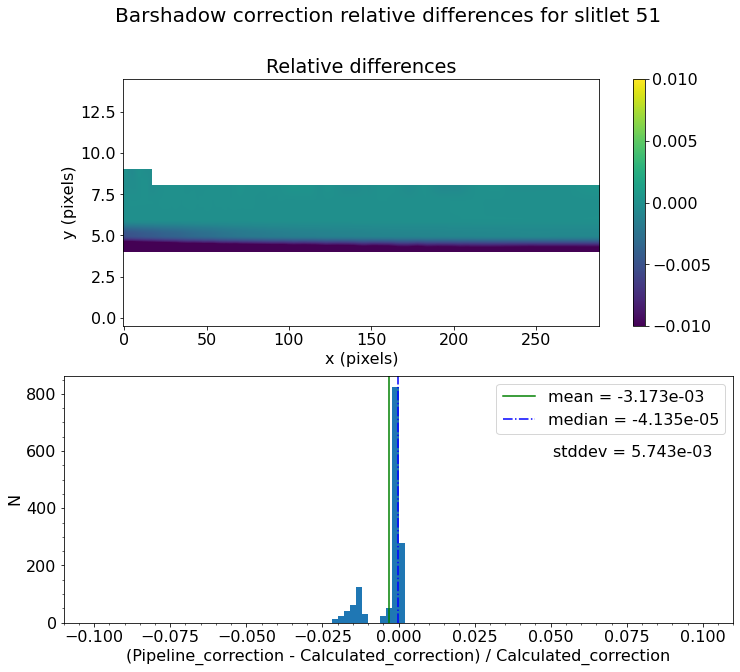

2021-02-20 01:41:41,164 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:41:41,164 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(

2021-02-20 01:41:41,165 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:41:41,166 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(

2021-02-20 01:41:41,242 - stpipe -


   Relative barshadow_correction  :   mean = -3.173e-03    median = -4.135e-05    stdev = 5.743e-03
    Maximum   Relativebarshadow_correction = 3.422e-04
    Minimum   Relativebarshadow_correction = -2.122e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 20%
                            ->  5xtheshold = 12%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 51? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: FAILED

Working with slitlet  52
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Referenc

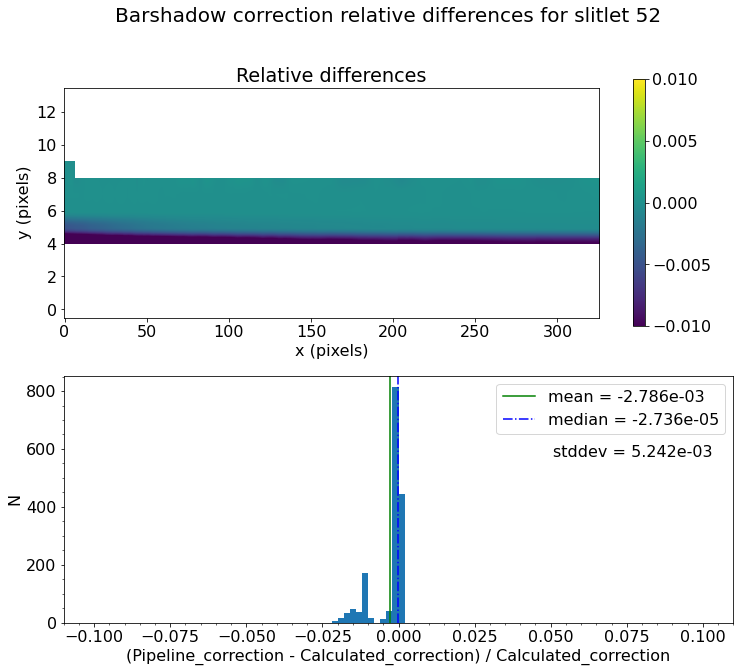

2021-02-20 01:41:43,785 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:41:43,786 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(

2021-02-20 01:41:43,787 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:41:43,788 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(

2021-02-20 01:41:43,874 - stpipe -


   Relative barshadow_correction  :   mean = -2.786e-03    median = -2.736e-05    stdev = 5.242e-03
    Maximum   Relativebarshadow_correction = 3.349e-04
    Minimum   Relativebarshadow_correction = -2.091e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 22%
                            ->  3xtheshold = 20%
                            ->  5xtheshold = 8%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 52? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  55
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

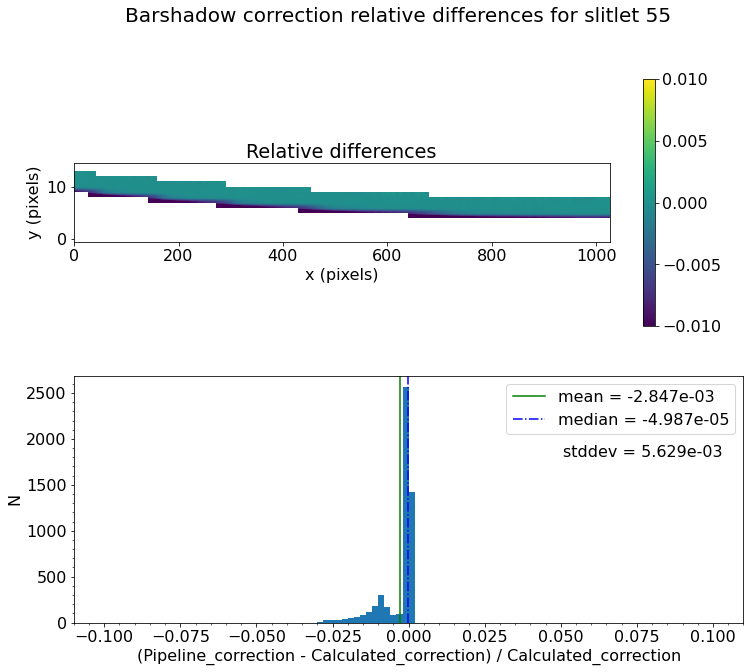

2021-02-20 01:41:45,936 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:41:45,937 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(




   Relative barshadow_correction  :   mean = -2.847e-03    median = -4.987e-05    stdev = 5.629e-03
    Maximum   Relativebarshadow_correction = 8.210e-04
    Minimum   Relativebarshadow_correction = -2.875e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 19%
                            ->  5xtheshold = 8%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 55? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  65
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

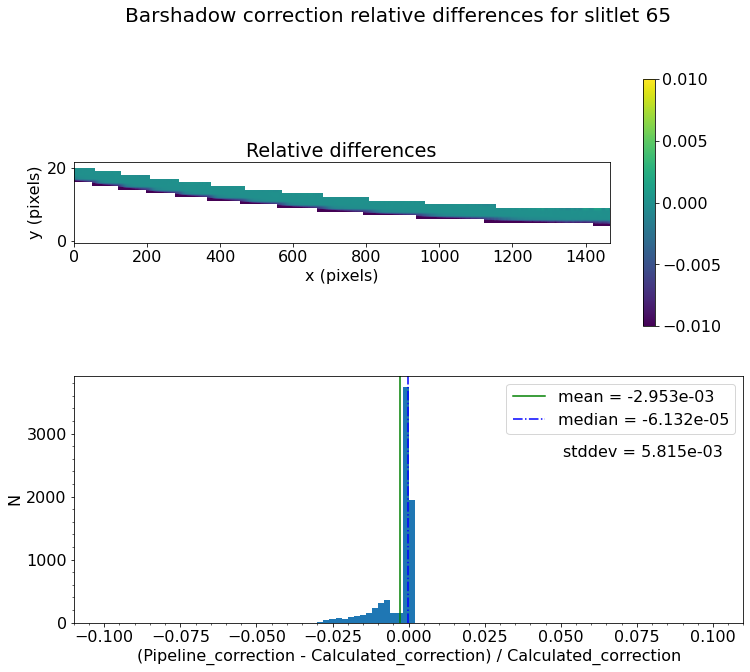


   Relative barshadow_correction  :   mean = -2.953e-03    median = -6.132e-05    stdev = 5.815e-03
    Maximum   Relativebarshadow_correction = 1.896e-03
    Minimum   Relativebarshadow_correction = -2.933e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 65? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  66
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

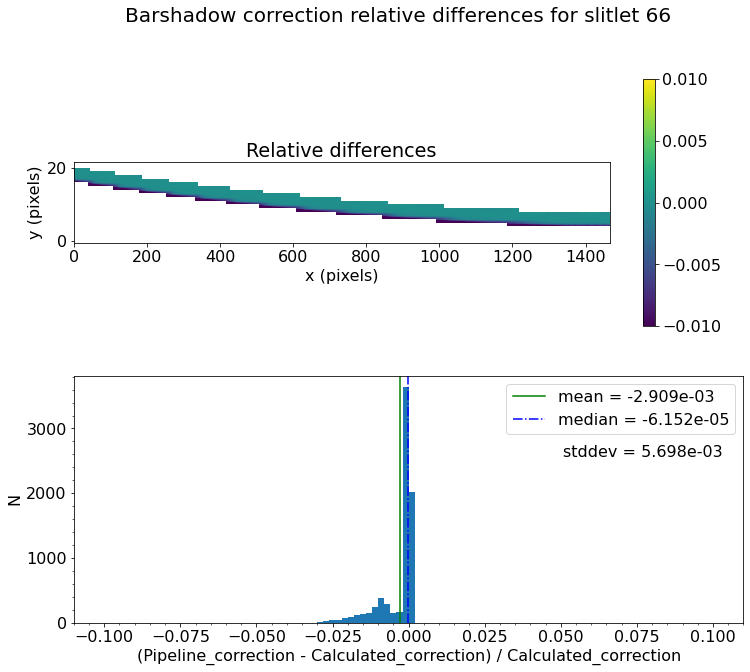


   Relative barshadow_correction  :   mean = -2.909e-03    median = -6.152e-05    stdev = 5.698e-03
    Maximum   Relativebarshadow_correction = 1.364e-03
    Minimum   Relativebarshadow_correction = -2.912e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 8%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 66? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  68
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

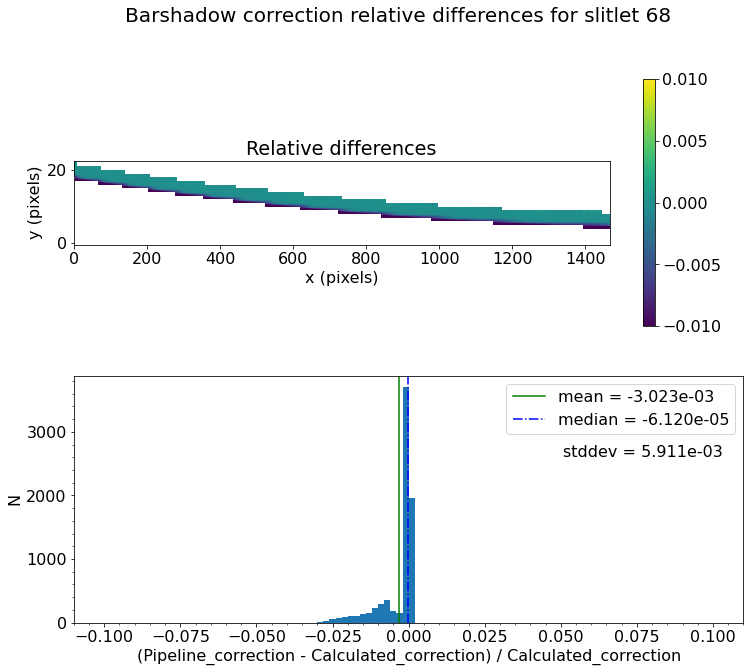

2021-02-20 01:41:52,761 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:41:52,762 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(




   Relative barshadow_correction  :   mean = -3.023e-03    median = -6.120e-05    stdev = 5.911e-03
    Maximum   Relativebarshadow_correction = 1.874e-03
    Minimum   Relativebarshadow_correction = -2.874e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 68? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  56
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

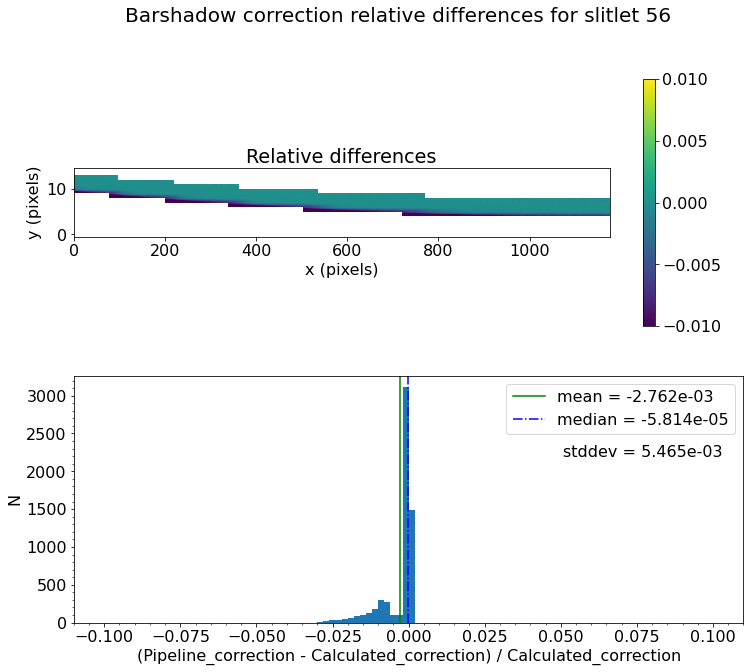


   Relative barshadow_correction  :   mean = -2.762e-03    median = -5.814e-05    stdev = 5.465e-03
    Maximum   Relativebarshadow_correction = 8.661e-04
    Minimum   Relativebarshadow_correction = -2.912e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 19%
                            ->  5xtheshold = 8%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 56? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED



2021-02-20 01:41:55,433 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:41:55,434 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(



Working with slitlet  57
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibrations/5.3_BarShadow/referenceFilesBS-20160401/jwst-nirspec-mos1x1.bsrf.fits
Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


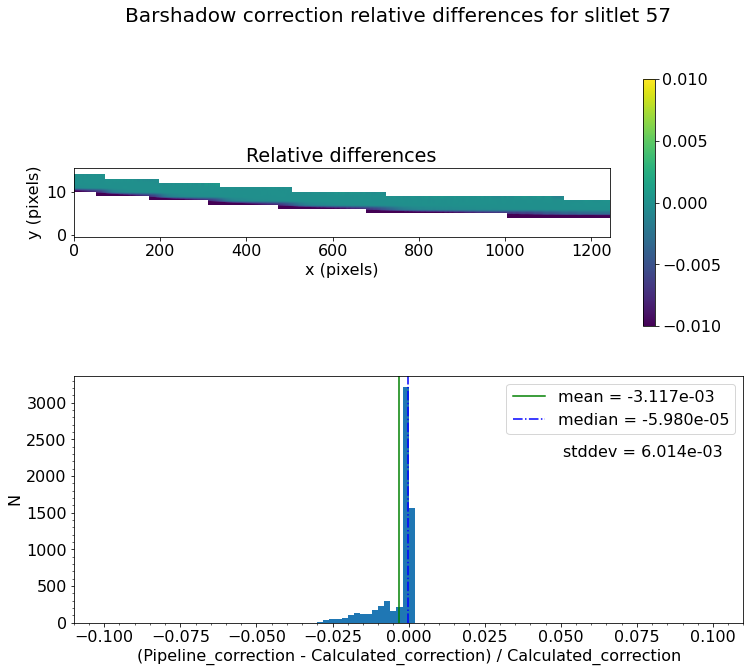


   Relative barshadow_correction  :   mean = -3.117e-03    median = -5.980e-05    stdev = 6.014e-03
    Maximum   Relativebarshadow_correction = 9.866e-04
    Minimum   Relativebarshadow_correction = -2.872e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 26%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 10%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 57? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  58
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibratio

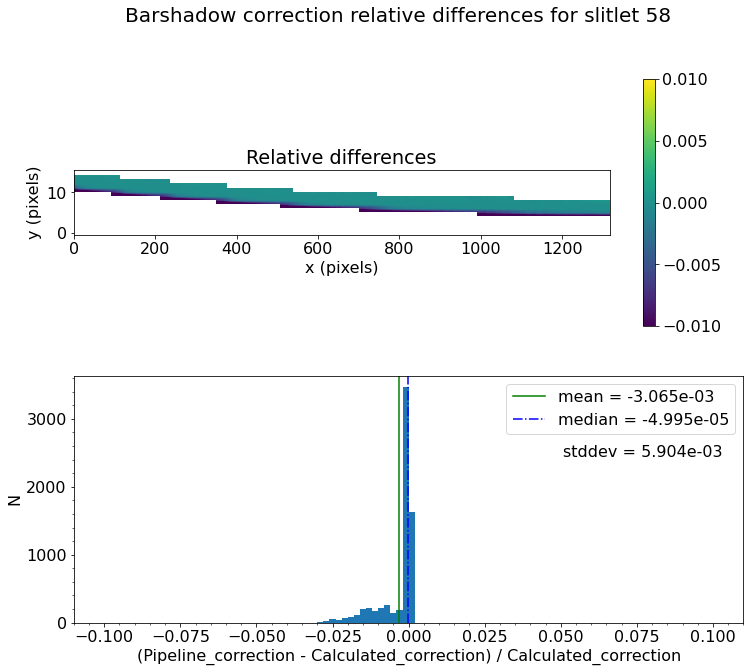


   Relative barshadow_correction  :   mean = -3.065e-03    median = -4.995e-05    stdev = 5.904e-03
    Maximum   Relativebarshadow_correction = 7.673e-04
    Minimum   Relativebarshadow_correction = -2.949e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 11%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 58? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: FAILED

Working with slitlet  59
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Referenc

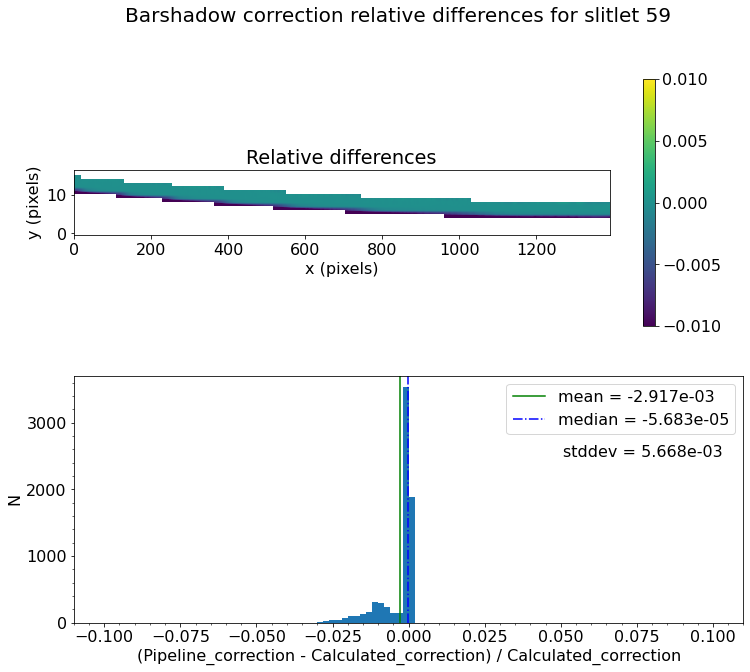


   Relative barshadow_correction  :   mean = -2.917e-03    median = -5.683e-05    stdev = 5.668e-03
    Maximum   Relativebarshadow_correction = 7.876e-04
    Minimum   Relativebarshadow_correction = -2.899e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 8%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 59? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  60
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

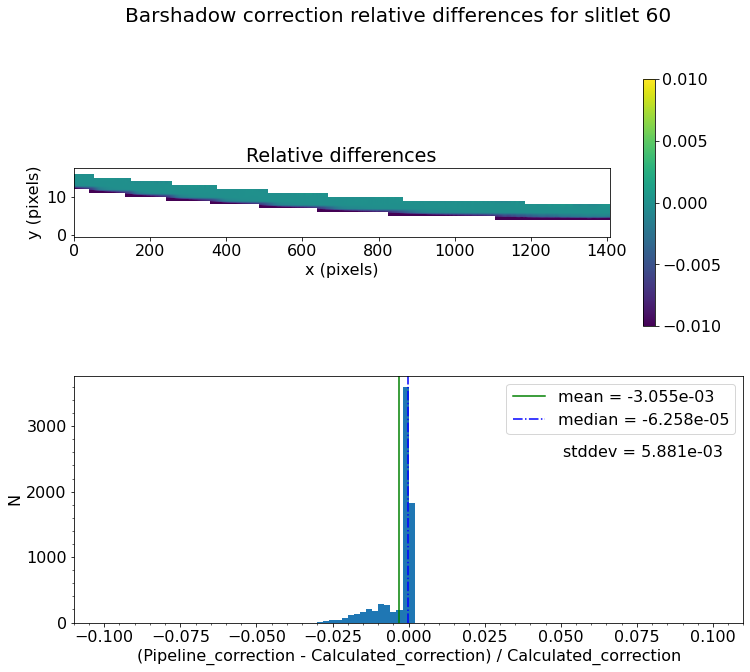


   Relative barshadow_correction  :   mean = -3.055e-03    median = -6.258e-05    stdev = 5.881e-03
    Maximum   Relativebarshadow_correction = 1.090e-03
    Minimum   Relativebarshadow_correction = -2.874e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 10%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 60? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  61
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibratio

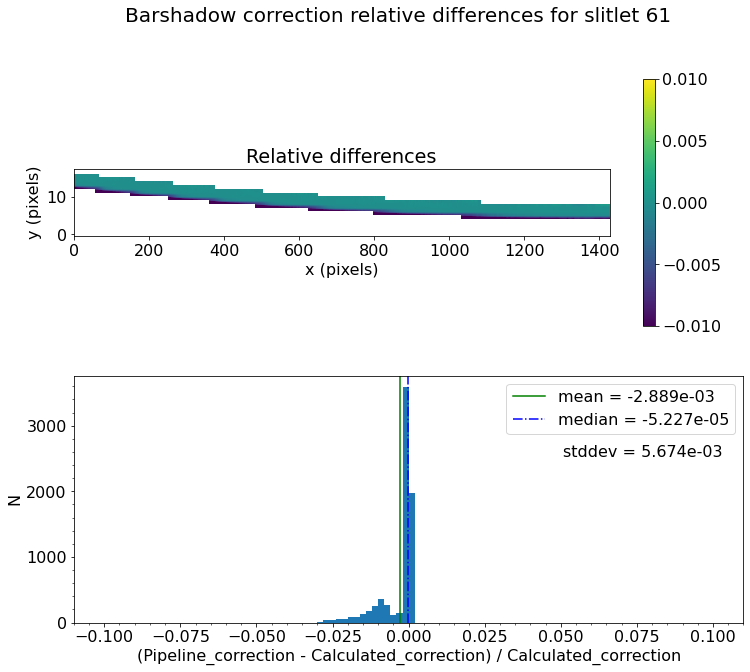


   Relative barshadow_correction  :   mean = -2.889e-03    median = -5.227e-05    stdev = 5.674e-03
    Maximum   Relativebarshadow_correction = 1.279e-03
    Minimum   Relativebarshadow_correction = -2.899e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 19%
                            ->  5xtheshold = 8%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 61? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  62
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

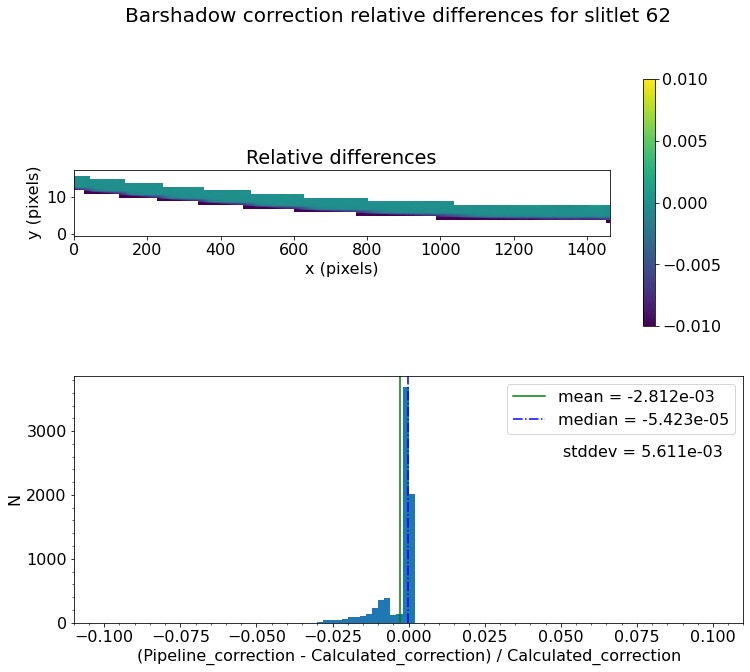


   Relative barshadow_correction  :   mean = -2.812e-03    median = -5.423e-05    stdev = 5.611e-03
    Maximum   Relativebarshadow_correction = 1.796e-03
    Minimum   Relativebarshadow_correction = -2.871e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 8%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 62? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  63
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

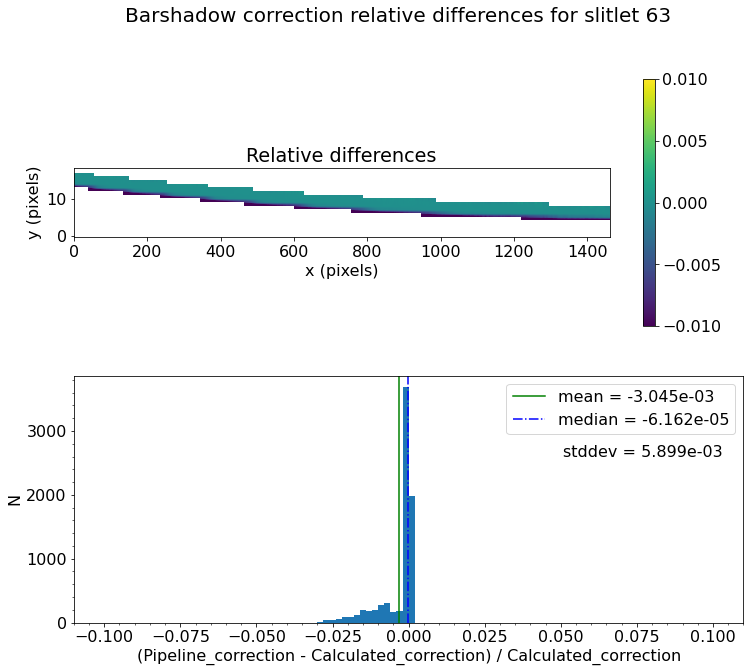


   Relative barshadow_correction  :   mean = -3.045e-03    median = -6.162e-05    stdev = 5.899e-03
    Maximum   Relativebarshadow_correction = 1.109e-03
    Minimum   Relativebarshadow_correction = -2.880e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 10%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 63? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  64
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibratio

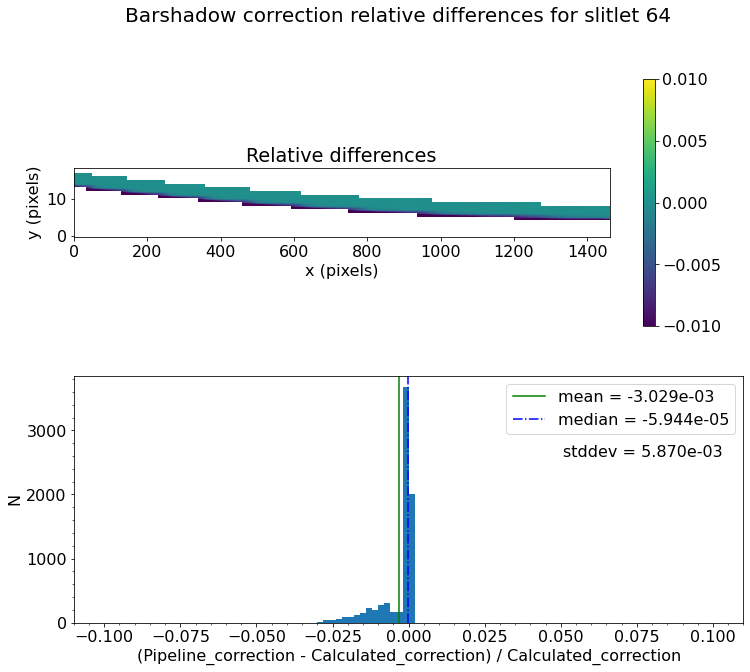


   Relative barshadow_correction  :   mean = -3.029e-03    median = -5.944e-05    stdev = 5.870e-03
    Maximum   Relativebarshadow_correction = 1.419e-03
    Minimum   Relativebarshadow_correction = -2.871e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 10%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 64? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  67
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibratio

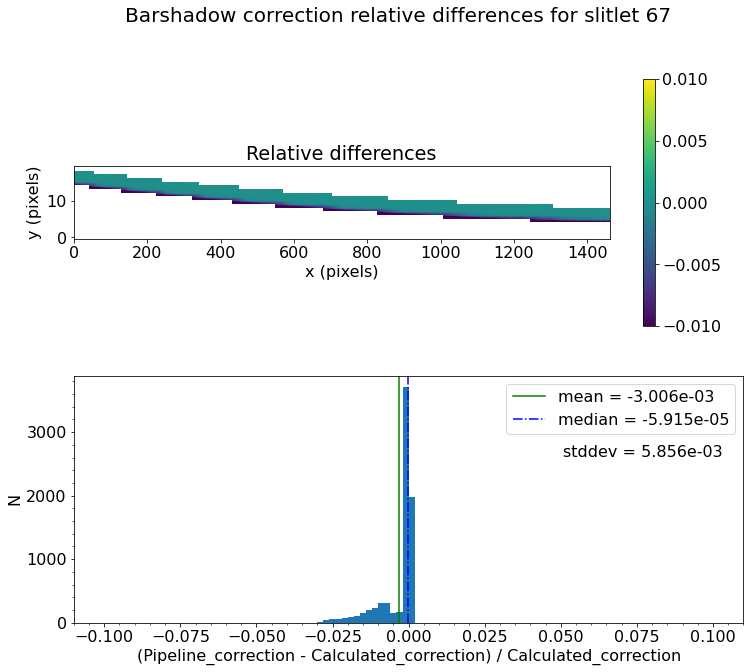


   Relative barshadow_correction  :   mean = -3.006e-03    median = -5.915e-05    stdev = 5.856e-03
    Maximum   Relativebarshadow_correction = 1.246e-03
    Minimum   Relativebarshadow_correction = -2.849e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 67? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED


 * The test of barshadow_correction for slitlet 53  PASSED.

 * The test of barshadow_correction for slitlet 54  PASSED.

 * The test of barshadow_correction for slitlet 42  PASSED.

 * The test of barshadow_correction for slitlet 43  PASSED.

 *

2021-02-20 01:42:31,541 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2021-02-20 01:42:31,542 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2021-02-20 01:42:31,543 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2021-02-20 01:42:31,545 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2021-02-20 01:42:31,546 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2021-02-20 01:42:31,547 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2021-02-20 01:42:31,548 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2021-02-20 01:42:31,549 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2021-02-20 01:42:31,550 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2021-02-20 01:42:31,552 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2021-02-20 0

2021-02-20 01:42:32,169 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2021-02-20 01:42:32,169 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0016.fits'.
2021-02-20 01:42:32,170 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2021-02-20 01:42:32,170 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.
2021-02-20 01:42:32,171 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.
2021-02-20 01:42:32,171 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0022.fits'.
2021-02-20 01:42:32,172 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0104.fits'.
2021-02-20 01:42:32,172 - stp

2021-02-20 01:42:39,454 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0143.fits
2021-02-20 01:42:39,771 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=6, nframes=1, groupgap=0
2021-02-20 01:42:39,771 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=10, nframes=1, groupgap=0
2021-02-20 01:42:39,887 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2021-02-20 01:42:40,275 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS2_uncal.fits>,).
2021-02-20 01:42:40,276 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output

2021-02-20 01:43:06,101 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 6
2021-02-20 01:43:06,102 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 1
2021-02-20 01:43:06,237 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done
2021-02-20 01:43:06,602 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(2048, 2048) from mos_g140m_line1_NRS2_uncal.fits>,).
2021-02-20 01:43:06,604 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/private/var/folders/62/jxd06t_15f5_4zsxs5zrgdfm0004vc/T/tmptf_e3mkh'}
2021-02-20 01:43:06,645 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference fi

2021-02-20 01:43:10,893 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs
2021-02-20 01:43:10,896 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done
2021-02-20 01:43:10,909 - stpipe.MSAFlagOpenStep - INFO - MSAFlagOpenStep instance created.
2021-02-20 01:43:11,361 - stpipe.MSAFlagOpenStep - INFO - Step MSAFlagOpenStep running with args (<ImageModel(2048, 2048) from mos_g140m_line1_NRS2_uncal.fits>,).
2021-02-20 01:43:11,362 - stpipe.MSAFlagOpenStep - INFO - Step MSAFlagOpenStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2021-02-20 01:43:11,374 - stpipe.MSAFlagOpenStep - INFO - Using reference file /Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0001.json
2021-02-20 01:43:11,375 - stpipe.Step - INFO - Step instance created.
2021-02-20 01:

2021-02-20 01:43:33,136 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 14
2021-02-20 01:43:33,136 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 104 1582
2021-02-20 01:43:33,137 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1221 1243
2021-02-20 01:43:33,263 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2021-02-20 01:43:33,272 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.249021000 -45.658685479 156.248891047 -45.658563629 156.248828487 -45.658595378 156.248958437 -45.658717230
2021-02-20 01:43:33,272 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.249021000 -45.658685479 156.248891047 -45.658563629 156.248828487 -45.658595378 156.248958437 -45.658717230
2021-02-20 01:43:34,177 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 15
2021-02-20 01:43:34,177 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 122 1604
2021-02-20 01:43:34,178 - stpipe.Extract2dStep - INFO - Subarray y-ex

2021-02-20 01:43:47,409 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 31
2021-02-20 01:43:47,410 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 1464
2021-02-20 01:43:47,410 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1367 1388
2021-02-20 01:43:47,533 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2021-02-20 01:43:47,541 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.248622769 -45.664184605 156.248492610 -45.664062392 156.248430047 -45.664094174 156.248560203 -45.664216388
2021-02-20 01:43:47,542 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.248622769 -45.664184605 156.248492610 -45.664062392 156.248430047 -45.664094174 156.248560203 -45.664216388
2021-02-20 01:43:48,446 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 32
2021-02-20 01:43:48,447 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 1432
2021-02-20 01:43:48,447 - stpipe.Extract2dStep - INFO - Subarray y-extent

2021-02-20 01:44:01,299 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 2
2021-02-20 01:44:01,300 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 124 1598
2021-02-20 01:44:01,300 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 331 351
2021-02-20 01:44:01,425 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2021-02-20 01:44:01,433 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.228476955 -45.637109572 156.228349188 -45.636989367 156.228287022 -45.637020983 156.228414786 -45.637141189
2021-02-20 01:44:01,433 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.228476955 -45.637109572 156.228349188 -45.636989367 156.228287022 -45.637020983 156.228414786 -45.637141189
2021-02-20 01:44:02,812 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 3
2021-02-20 01:44:02,813 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 116 1589
2021-02-20 01:44:02,813 - stpipe.Extract2dStep - INFO - Subarray y-extent

2021-02-20 01:44:15,235 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 30
2021-02-20 01:44:15,235 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 1457
2021-02-20 01:44:15,236 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 700 719
2021-02-20 01:44:15,360 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2021-02-20 01:44:15,367 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.232568977 -45.648183467 156.232440513 -45.648062572 156.232378263 -45.648094230 156.232506725 -45.648215126
2021-02-20 01:44:15,368 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.232568977 -45.648183467 156.232440513 -45.648062572 156.232378263 -45.648094230 156.232506725 -45.648215126
2021-02-20 01:44:16,828 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 34
2021-02-20 01:44:16,828 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 1394
2021-02-20 01:44:16,829 - stpipe.Extract2dStep - INFO - Subarray y-extents 

2021-02-20 01:44:29,783 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 49
2021-02-20 01:44:29,783 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 1067
2021-02-20 01:44:29,784 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 632 647
2021-02-20 01:44:29,907 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2021-02-20 01:44:29,916 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.218210913 -45.652969013 156.218083107 -45.652848076 156.218021073 -45.652879740 156.218148877 -45.653000678
2021-02-20 01:44:29,916 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.218210913 -45.652969013 156.218083107 -45.652848076 156.218021073 -45.652879740 156.218148877 -45.653000678
2021-02-20 01:44:30,871 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 50
2021-02-20 01:44:30,871 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 1048
2021-02-20 01:44:30,872 - stpipe.Extract2dStep - INFO - Subarray y-extents 

2021-02-20 01:44:40,185 - stpipe.SourceTypeStep - INFO - source_id=38, stellarity=0.0000, type=EXTENDED
2021-02-20 01:44:40,186 - stpipe.SourceTypeStep - INFO - source_id=39, stellarity=0.0000, type=EXTENDED
2021-02-20 01:44:40,187 - stpipe.SourceTypeStep - INFO - source_id=41, stellarity=0.0000, type=EXTENDED
2021-02-20 01:44:40,187 - stpipe.SourceTypeStep - INFO - source_id=53, stellarity=0.0000, type=EXTENDED
2021-02-20 01:44:40,188 - stpipe.SourceTypeStep - INFO - source_id=54, stellarity=0.0000, type=EXTENDED
2021-02-20 01:44:40,189 - stpipe.SourceTypeStep - INFO - source_id=1, stellarity=0.0000, type=EXTENDED
2021-02-20 01:44:40,189 - stpipe.SourceTypeStep - INFO - source_id=2, stellarity=0.0000, type=EXTENDED
2021-02-20 01:44:40,190 - stpipe.SourceTypeStep - INFO - source_id=3, stellarity=0.0000, type=EXTENDED
2021-02-20 01:44:40,191 - stpipe.SourceTypeStep - INFO - source_id=4, stellarity=0.0000, type=EXTENDED
2021-02-20 01:44:40,192 - stpipe.SourceTypeStep - INFO - source_id=5

2021-02-20 01:46:14,148 - stpipe.FlatFieldStep - INFO - Working on slit 50
2021-02-20 01:46:15,365 - stpipe.FlatFieldStep - INFO - Working on slit 51
2021-02-20 01:46:16,554 - stpipe.FlatFieldStep - INFO - Working on slit 52
2021-02-20 01:46:17,708 - stpipe.FlatFieldStep - INFO - Working on slit 55
2021-02-20 01:46:18,098 - stpipe.FlatFieldStep - INFO - Working on slit 56
2021-02-20 01:46:18,328 - stpipe.FlatFieldStep - INFO - Working on slit 57
2021-02-20 01:46:19,983 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep done
2021-02-20 01:46:20,091 - stpipe.PathLossStep - INFO - PathLossStep instance created.
2021-02-20 01:46:21,161 - stpipe.PathLossStep - INFO - Step PathLossStep running with args (<MultiSlitModel from mos_g140m_line1_NRS2_uncal.fits>,).
2021-02-20 01:46:21,162 - stpipe.PathLossStep - INFO - Step PathLossStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index':

2021-02-20 01:46:42,082 - stpipe.BarShadowStep - INFO - Working on slitlet 39
2021-02-20 01:46:42,196 - stpipe.BarShadowStep - INFO - Working on slitlet 41
2021-02-20 01:46:42,308 - stpipe.BarShadowStep - INFO - Working on slitlet 53
2021-02-20 01:46:42,375 - stpipe.BarShadowStep - INFO - Working on slitlet 54
2021-02-20 01:46:42,438 - stpipe.BarShadowStep - INFO - Working on slitlet 1
2021-02-20 01:46:42,550 - stpipe.BarShadowStep - INFO - Working on slitlet 2
2021-02-20 01:46:42,666 - stpipe.BarShadowStep - INFO - Working on slitlet 3
2021-02-20 01:46:42,783 - stpipe.BarShadowStep - INFO - Working on slitlet 4
2021-02-20 01:46:42,901 - stpipe.BarShadowStep - INFO - Working on slitlet 5
2021-02-20 01:46:43,022 - stpipe.BarShadowStep - INFO - Working on slitlet 12
2021-02-20 01:46:43,147 - stpipe.BarShadowStep - INFO - Working on slitlet 13
2021-02-20 01:46:43,261 - stpipe.BarShadowStep - INFO - Working on slitlet 20
2021-02-20 01:46:43,385 - stpipe.BarShadowStep - INFO - Working on sl

Looping over open slitlets...
Working with slitlet  6
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibrations/5.3_BarShadow/referenceFilesBS-20160401/jwst-nirspec-mos1x1.bsrf.fits
Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


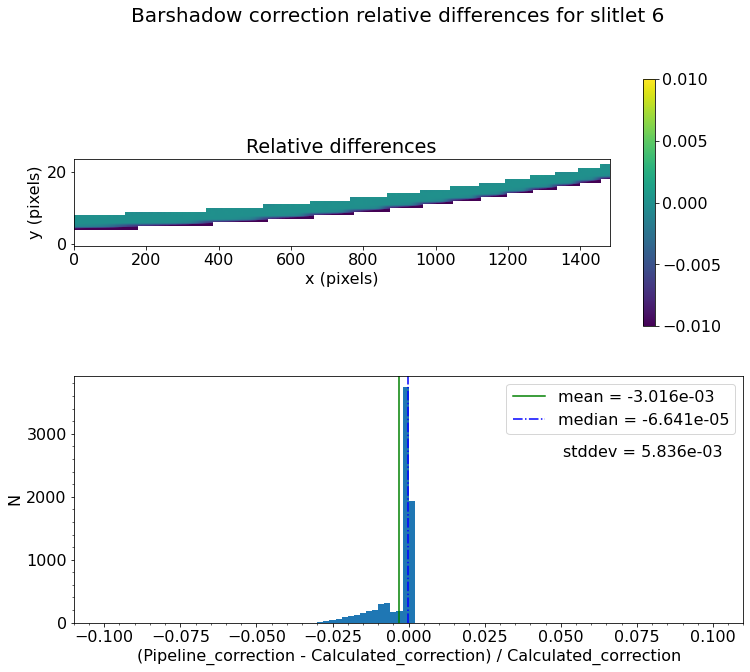


   Relative barshadow_correction  :   mean = -3.016e-03    median = -6.641e-05    stdev = 5.836e-03
    Maximum   Relativebarshadow_correction = 1.718e-03
    Minimum   Relativebarshadow_correction = -2.815e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 10%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 6? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  7
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibrations

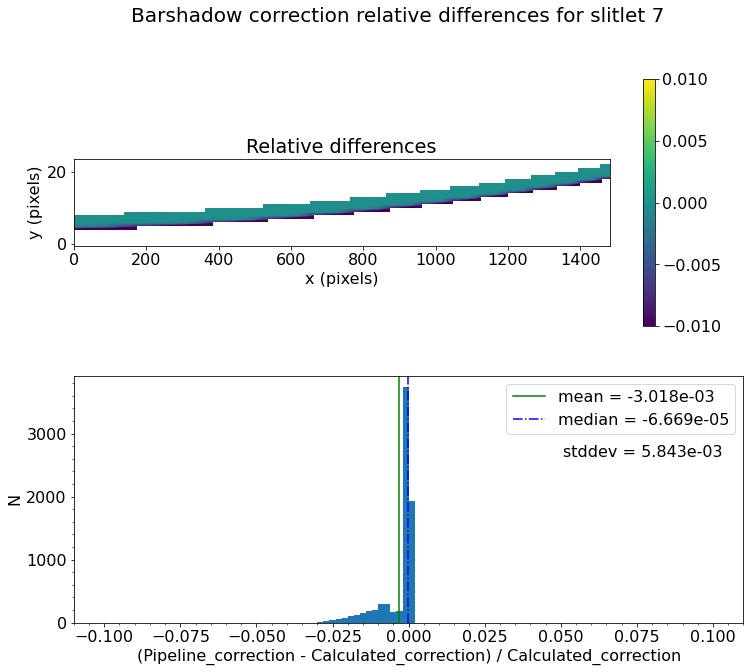


   Relative barshadow_correction  :   mean = -3.018e-03    median = -6.669e-05    stdev = 5.843e-03
    Maximum   Relativebarshadow_correction = 1.708e-03
    Minimum   Relativebarshadow_correction = -2.869e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 10%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 7? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  8
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibrations

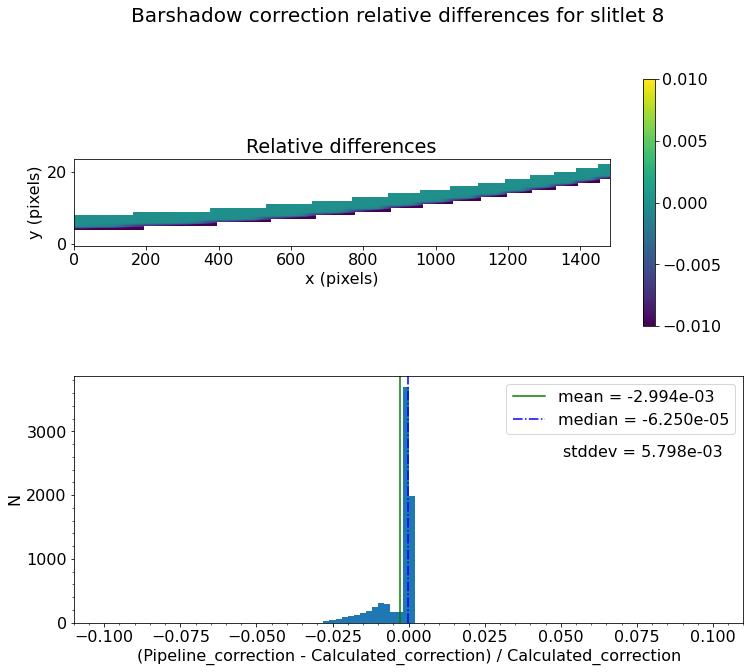


   Relative barshadow_correction  :   mean = -2.994e-03    median = -6.250e-05    stdev = 5.798e-03
    Maximum   Relativebarshadow_correction = 1.902e-03
    Minimum   Relativebarshadow_correction = -2.855e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 8? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  9
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibrations/

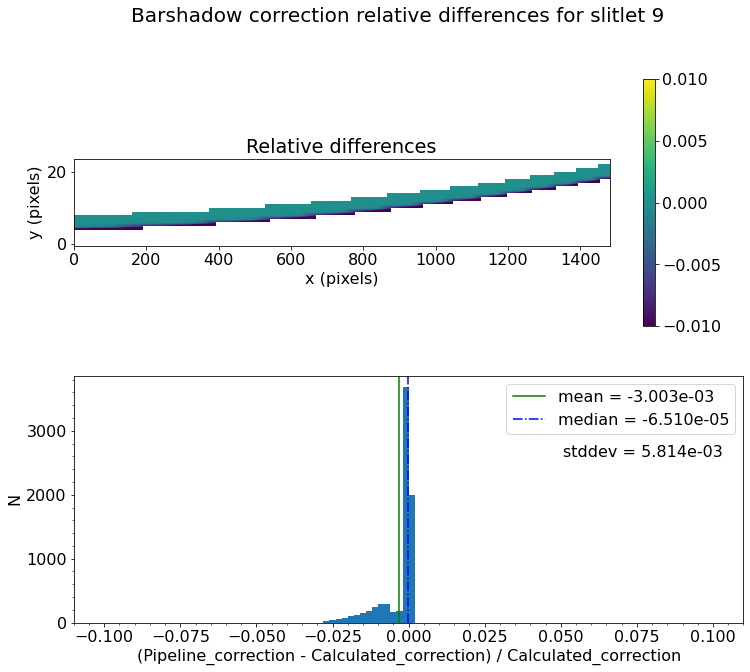


   Relative barshadow_correction  :   mean = -3.003e-03    median = -6.510e-05    stdev = 5.814e-03
    Maximum   Relativebarshadow_correction = 1.475e-03
    Minimum   Relativebarshadow_correction = -2.841e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 9? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  10
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibrations

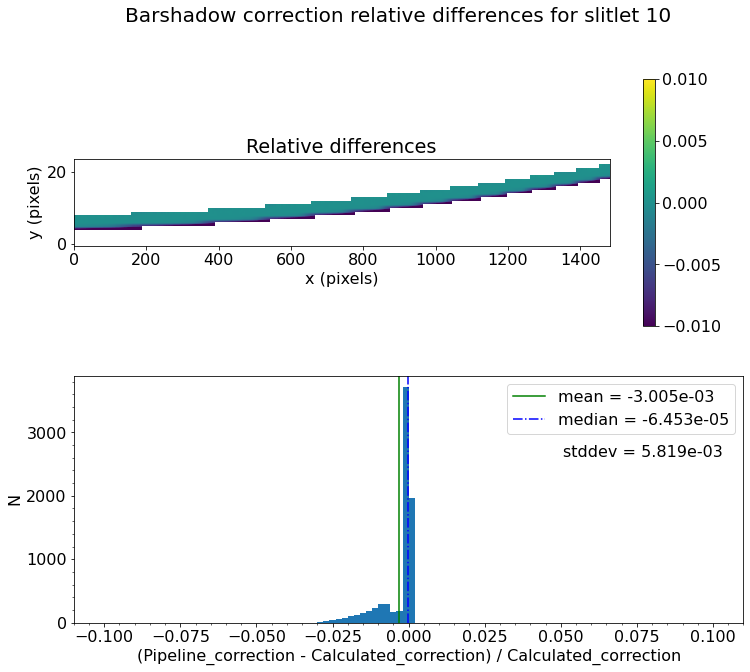


   Relative barshadow_correction  :   mean = -3.005e-03    median = -6.453e-05    stdev = 5.819e-03
    Maximum   Relativebarshadow_correction = 1.839e-03
    Minimum   Relativebarshadow_correction = -2.832e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 10? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  11
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

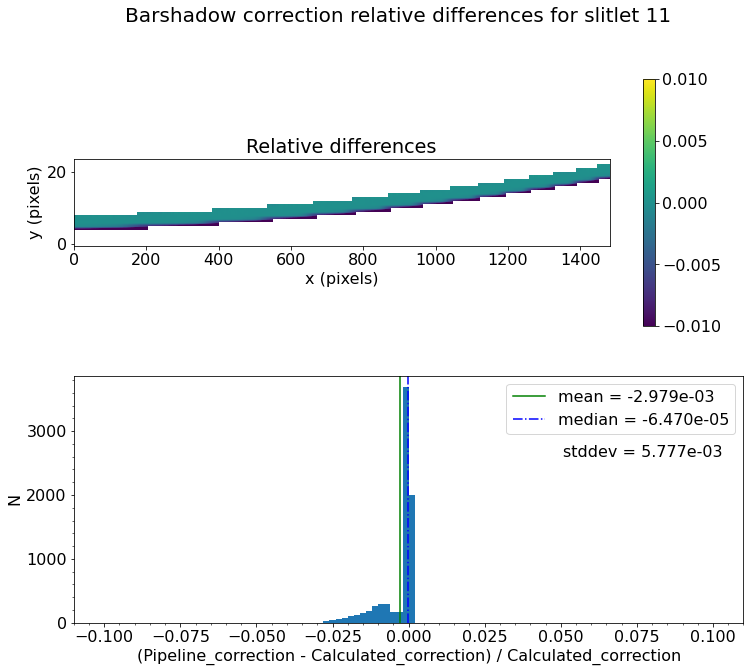


   Relative barshadow_correction  :   mean = -2.979e-03    median = -6.470e-05    stdev = 5.777e-03
    Maximum   Relativebarshadow_correction = 1.923e-03
    Minimum   Relativebarshadow_correction = -2.812e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 11? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  14
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

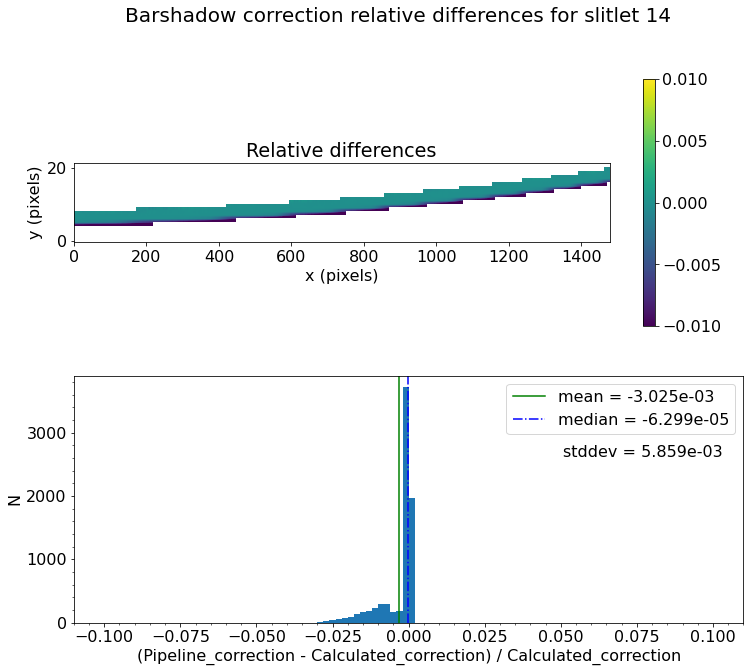


   Relative barshadow_correction  :   mean = -3.025e-03    median = -6.299e-05    stdev = 5.859e-03
    Maximum   Relativebarshadow_correction = 1.204e-03
    Minimum   Relativebarshadow_correction = -2.914e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 10%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 14? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  15
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibratio

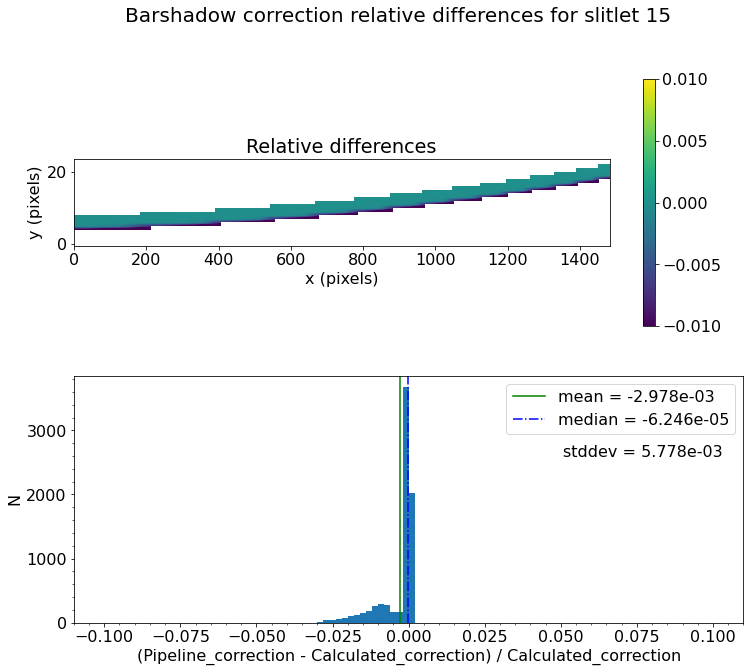


   Relative barshadow_correction  :   mean = -2.978e-03    median = -6.246e-05    stdev = 5.778e-03
    Maximum   Relativebarshadow_correction = 1.915e-03
    Minimum   Relativebarshadow_correction = -2.869e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 15? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  16
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

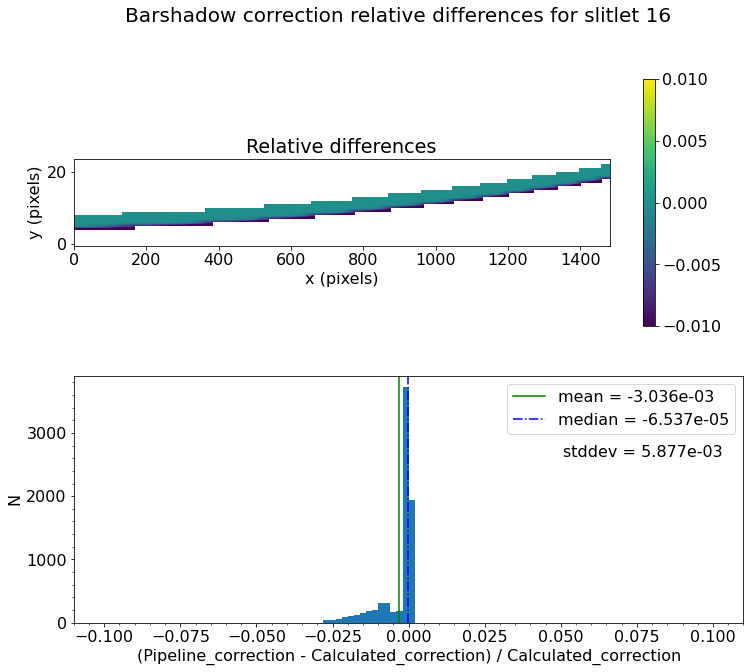


   Relative barshadow_correction  :   mean = -3.036e-03    median = -6.537e-05    stdev = 5.877e-03
    Maximum   Relativebarshadow_correction = 1.679e-03
    Minimum   Relativebarshadow_correction = -2.866e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 10%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 16? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  17
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibratio

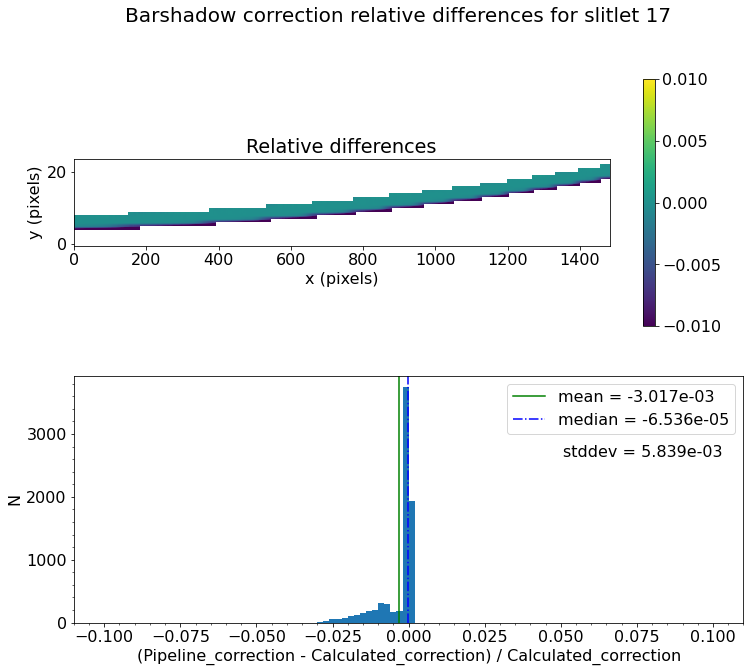


   Relative barshadow_correction  :   mean = -3.017e-03    median = -6.536e-05    stdev = 5.839e-03
    Maximum   Relativebarshadow_correction = 1.718e-03
    Minimum   Relativebarshadow_correction = -2.817e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 10%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 17? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  18
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibratio

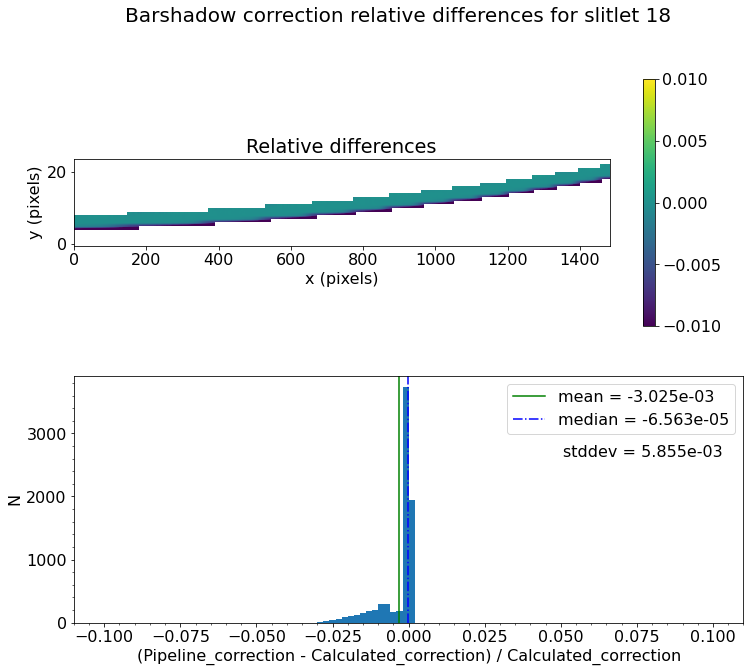


   Relative barshadow_correction  :   mean = -3.025e-03    median = -6.563e-05    stdev = 5.855e-03
    Maximum   Relativebarshadow_correction = 1.725e-03
    Minimum   Relativebarshadow_correction = -2.825e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 10%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 18? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  19
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibratio

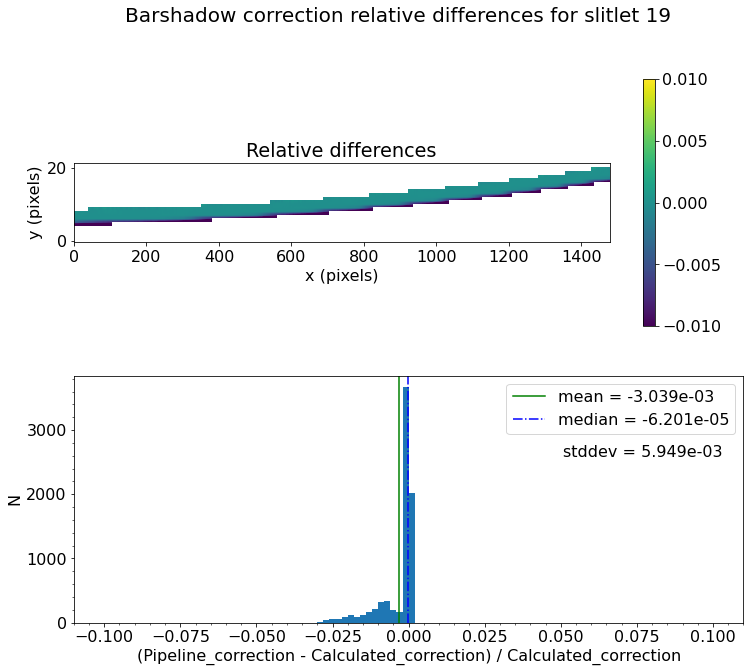


   Relative barshadow_correction  :   mean = -3.039e-03    median = -6.201e-05    stdev = 5.949e-03
    Maximum   Relativebarshadow_correction = 1.905e-03
    Minimum   Relativebarshadow_correction = -2.937e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 19? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  21
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

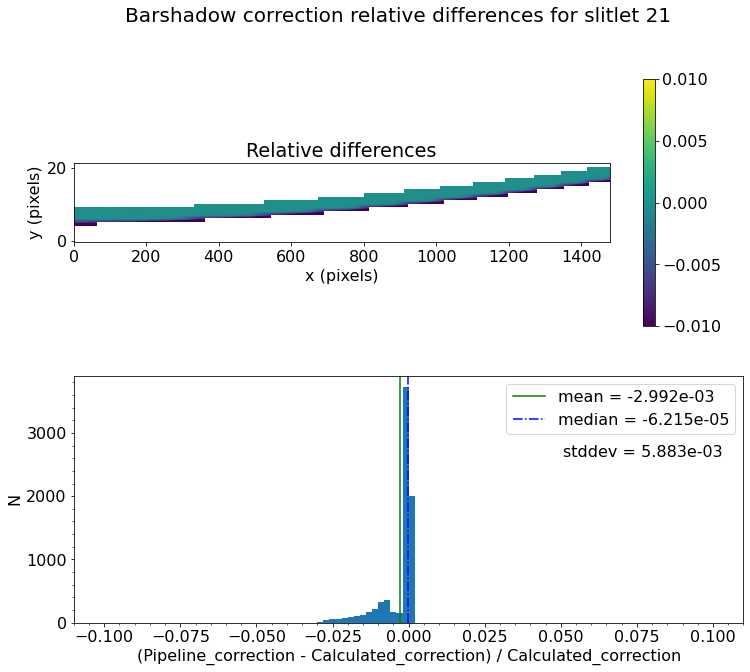


   Relative barshadow_correction  :   mean = -2.992e-03    median = -6.215e-05    stdev = 5.883e-03
    Maximum   Relativebarshadow_correction = 1.457e-03
    Minimum   Relativebarshadow_correction = -2.892e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 21? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  25
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

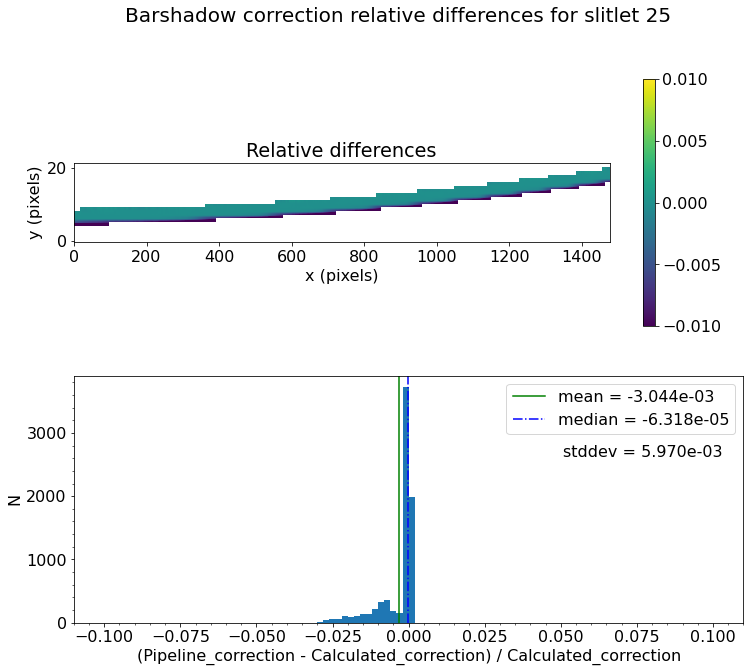


   Relative barshadow_correction  :   mean = -3.044e-03    median = -6.318e-05    stdev = 5.970e-03
    Maximum   Relativebarshadow_correction = 1.541e-03
    Minimum   Relativebarshadow_correction = -2.959e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 25? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  26
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

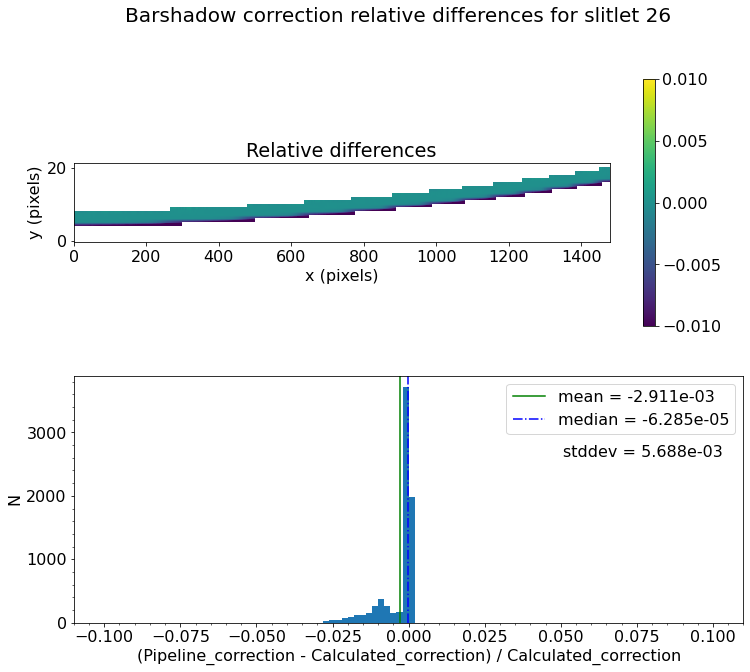


   Relative barshadow_correction  :   mean = -2.911e-03    median = -6.285e-05    stdev = 5.688e-03
    Maximum   Relativebarshadow_correction = 1.757e-03
    Minimum   Relativebarshadow_correction = -2.821e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 19%
                            ->  5xtheshold = 8%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 26? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  27
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

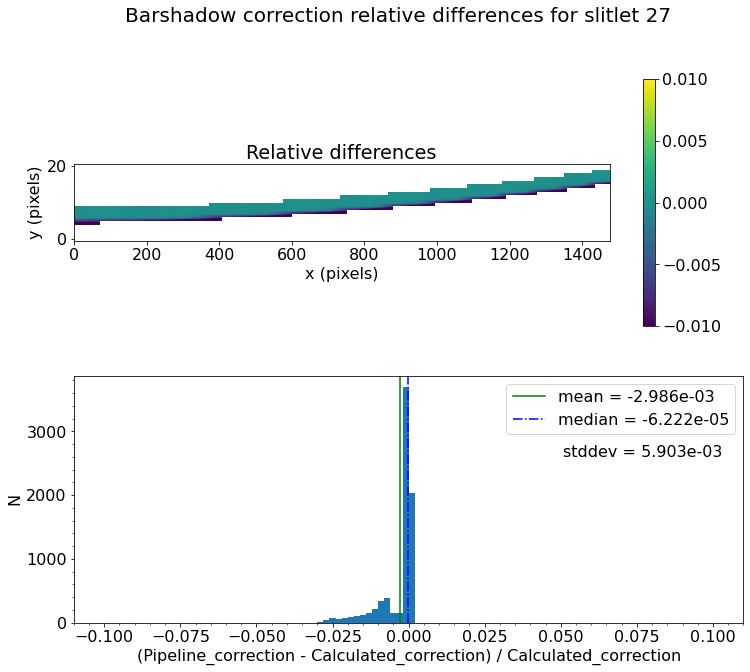


   Relative barshadow_correction  :   mean = -2.986e-03    median = -6.222e-05    stdev = 5.903e-03
    Maximum   Relativebarshadow_correction = 1.925e-03
    Minimum   Relativebarshadow_correction = -2.912e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 27? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  29
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

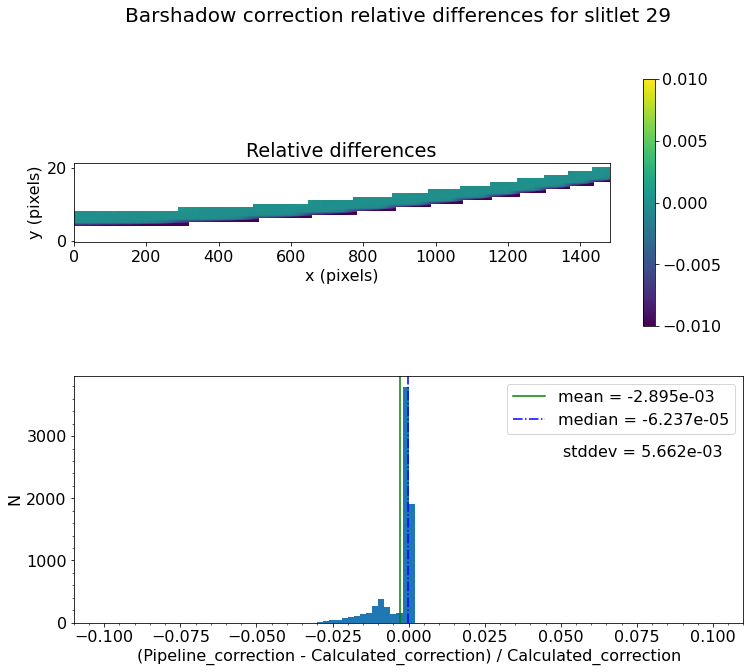


   Relative barshadow_correction  :   mean = -2.895e-03    median = -6.237e-05    stdev = 5.662e-03
    Maximum   Relativebarshadow_correction = 2.029e-03
    Minimum   Relativebarshadow_correction = -2.941e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 19%
                            ->  5xtheshold = 8%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 29? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  31
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

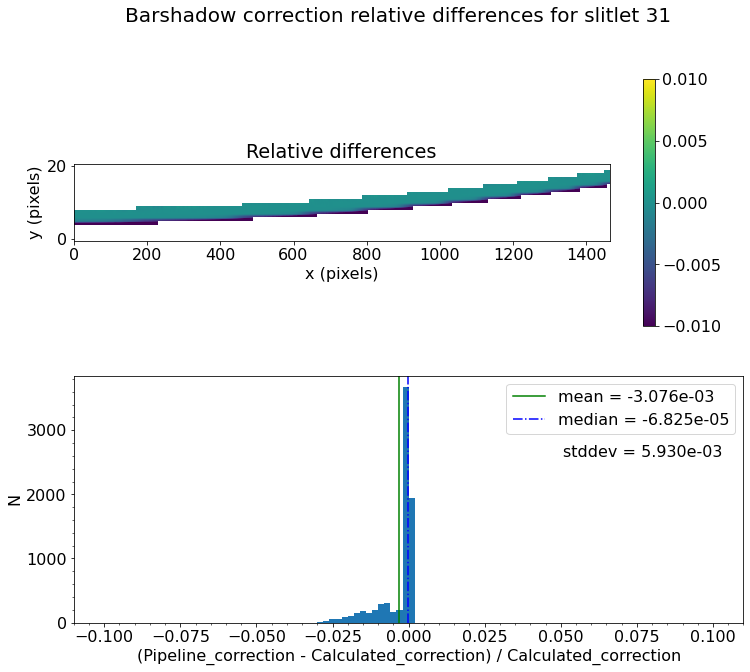


   Relative barshadow_correction  :   mean = -3.076e-03    median = -6.825e-05    stdev = 5.930e-03
    Maximum   Relativebarshadow_correction = 1.367e-03
    Minimum   Relativebarshadow_correction = -2.841e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 10%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 31? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  32
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibratio

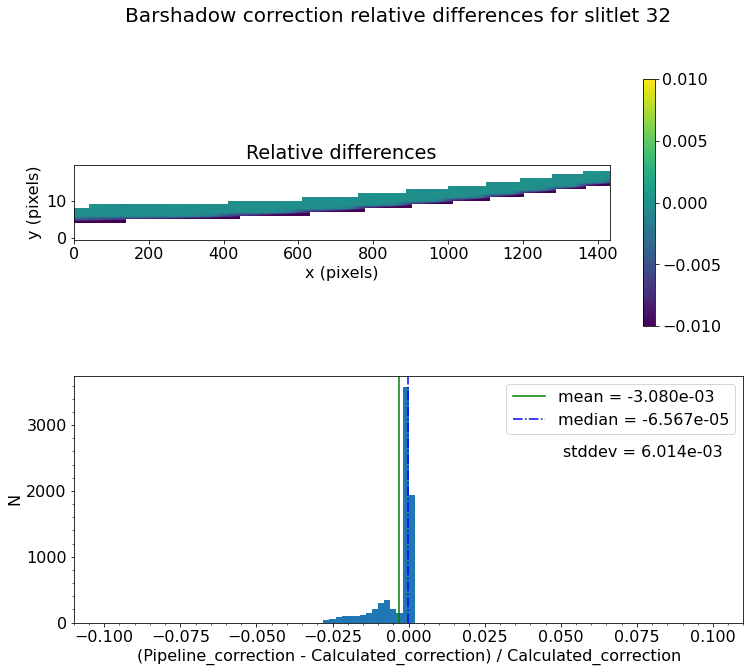


   Relative barshadow_correction  :   mean = -3.080e-03    median = -6.567e-05    stdev = 6.014e-03
    Maximum   Relativebarshadow_correction = 1.415e-03
    Minimum   Relativebarshadow_correction = -2.816e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 32? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  33
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

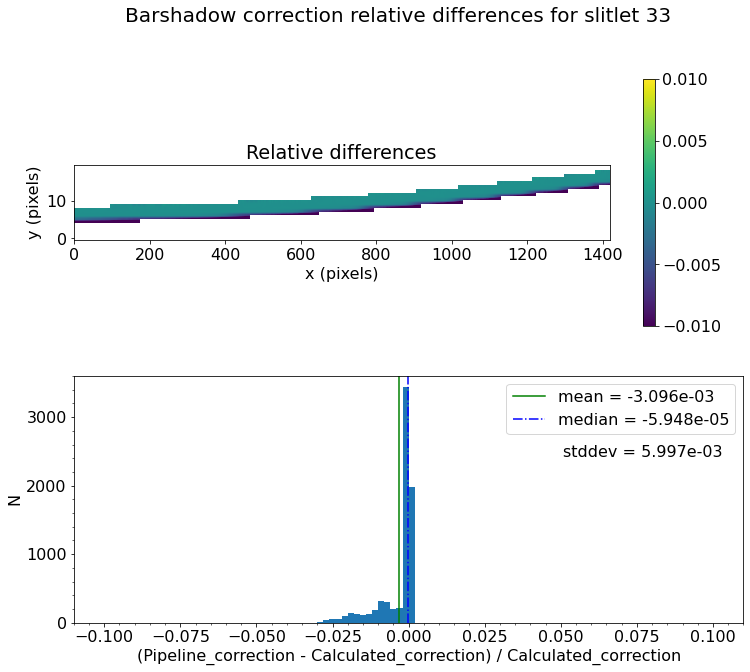


   Relative barshadow_correction  :   mean = -3.096e-03    median = -5.948e-05    stdev = 5.997e-03
    Maximum   Relativebarshadow_correction = 2.072e-03
    Minimum   Relativebarshadow_correction = -2.881e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 26%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 10%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 33? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  35
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibratio

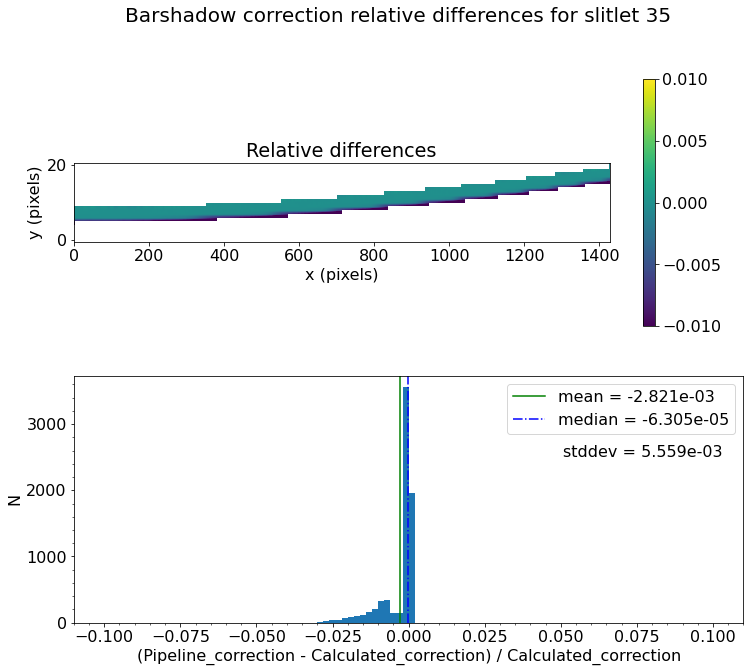


   Relative barshadow_correction  :   mean = -2.821e-03    median = -6.305e-05    stdev = 5.559e-03
    Maximum   Relativebarshadow_correction = 1.381e-03
    Minimum   Relativebarshadow_correction = -2.871e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 8%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 35? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  37
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

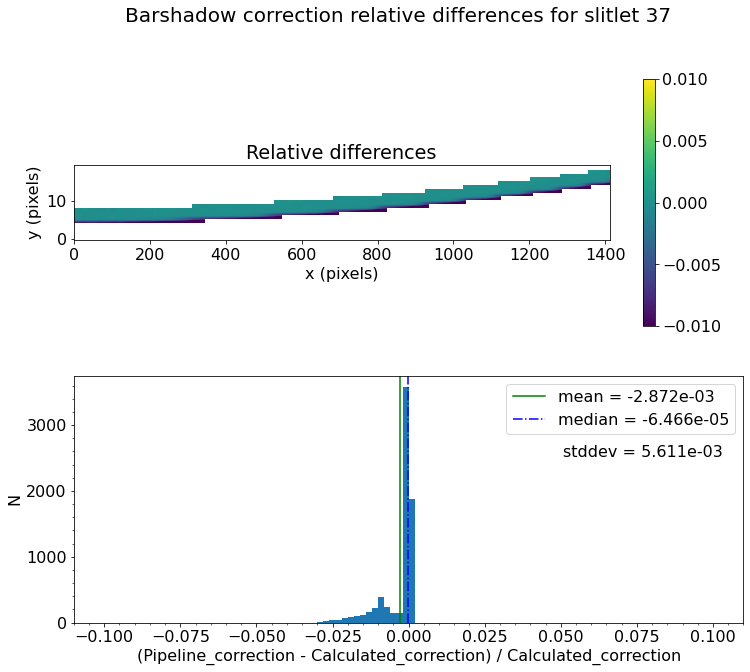


   Relative barshadow_correction  :   mean = -2.872e-03    median = -6.466e-05    stdev = 5.611e-03
    Maximum   Relativebarshadow_correction = 1.789e-03
    Minimum   Relativebarshadow_correction = -2.886e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 19%
                            ->  5xtheshold = 8%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 37? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  38
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

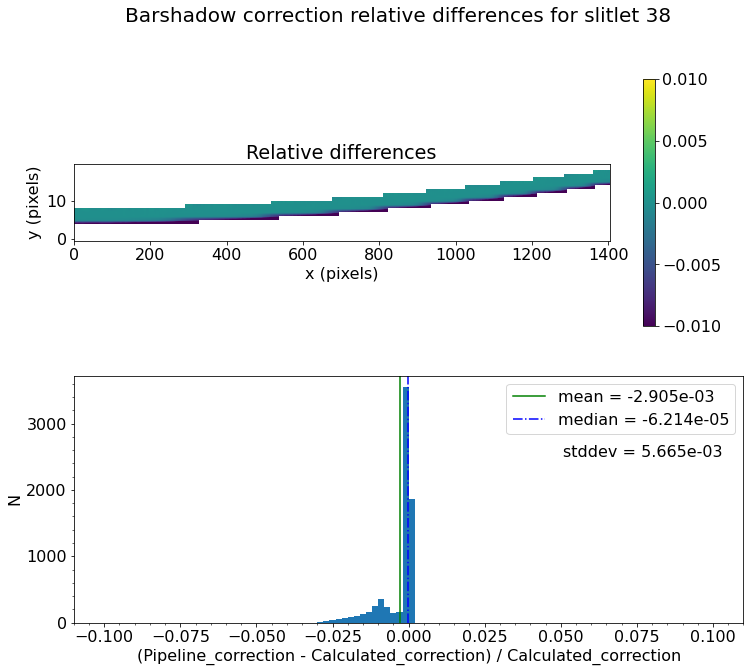


   Relative barshadow_correction  :   mean = -2.905e-03    median = -6.214e-05    stdev = 5.665e-03
    Maximum   Relativebarshadow_correction = 2.042e-03
    Minimum   Relativebarshadow_correction = -2.930e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 19%
                            ->  5xtheshold = 8%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 38? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  39
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

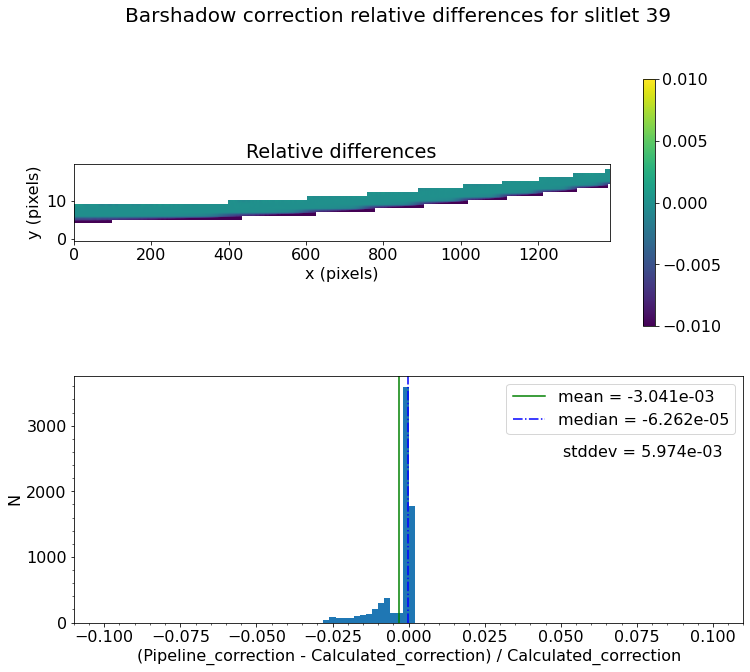


   Relative barshadow_correction  :   mean = -3.041e-03    median = -6.262e-05    stdev = 5.974e-03
    Maximum   Relativebarshadow_correction = 1.176e-03
    Minimum   Relativebarshadow_correction = -2.788e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 39? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  41
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

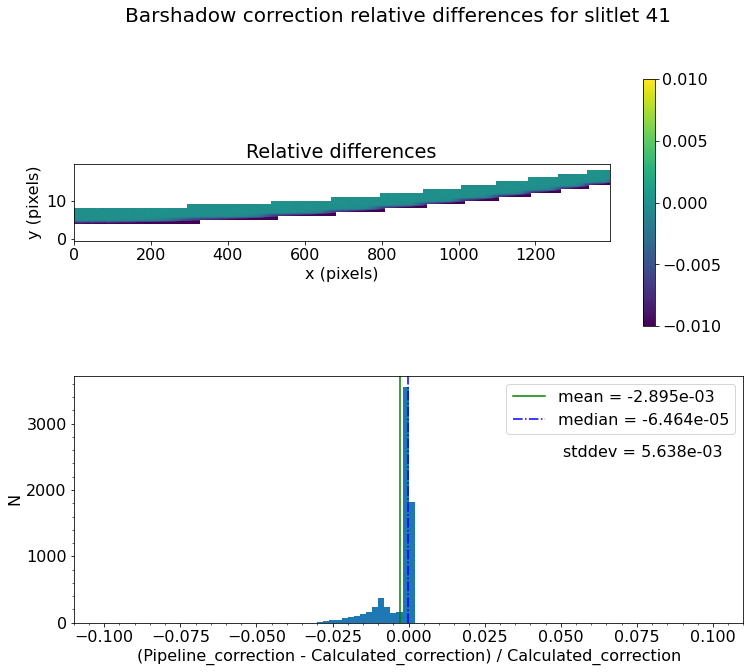

2021-02-20 01:47:38,418 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:47:38,419 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(




   Relative barshadow_correction  :   mean = -2.895e-03    median = -6.464e-05    stdev = 5.638e-03
    Maximum   Relativebarshadow_correction = 1.679e-03
    Minimum   Relativebarshadow_correction = -2.888e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 19%
                            ->  5xtheshold = 8%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 41? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  53
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

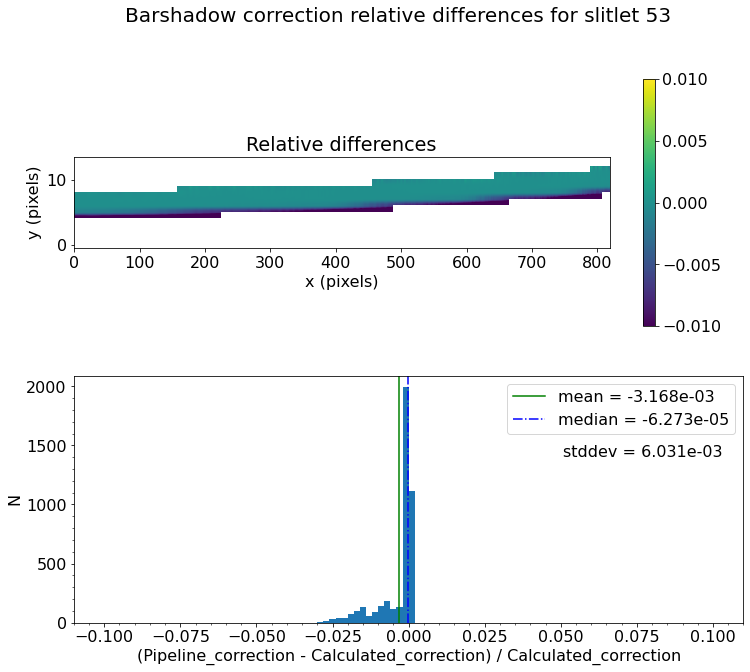

2021-02-20 01:47:40,252 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:47:40,253 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(

2021-02-20 01:47:40,321 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:47:40,321 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(




   Relative barshadow_correction  :   mean = -3.168e-03    median = -6.273e-05    stdev = 6.031e-03
    Maximum   Relativebarshadow_correction = 1.761e-03
    Minimum   Relativebarshadow_correction = -2.824e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 26%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 11%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 53? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: FAILED

Working with slitlet  54
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Referenc

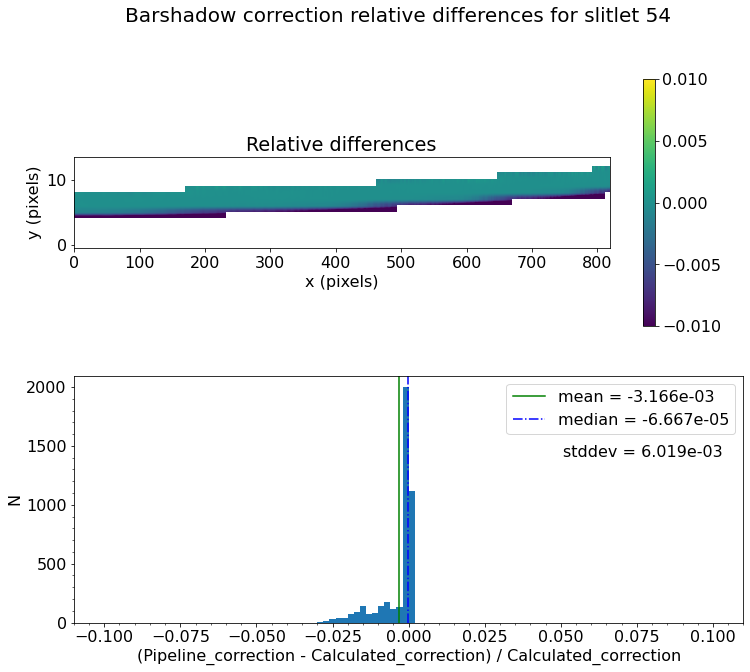

2021-02-20 01:47:42,184 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:47:42,185 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(




   Relative barshadow_correction  :   mean = -3.166e-03    median = -6.667e-05    stdev = 6.019e-03
    Maximum   Relativebarshadow_correction = 1.585e-03
    Minimum   Relativebarshadow_correction = -2.815e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 26%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 11%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 54? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: FAILED

Working with slitlet  1
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference

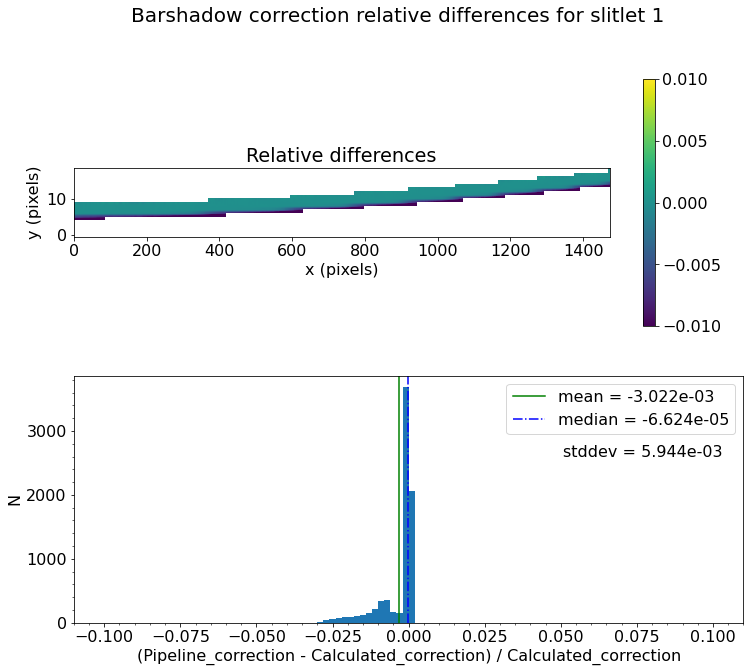


   Relative barshadow_correction  :   mean = -3.022e-03    median = -6.624e-05    stdev = 5.944e-03
    Maximum   Relativebarshadow_correction = 1.209e-03
    Minimum   Relativebarshadow_correction = -2.936e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 1? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  2
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibrations/

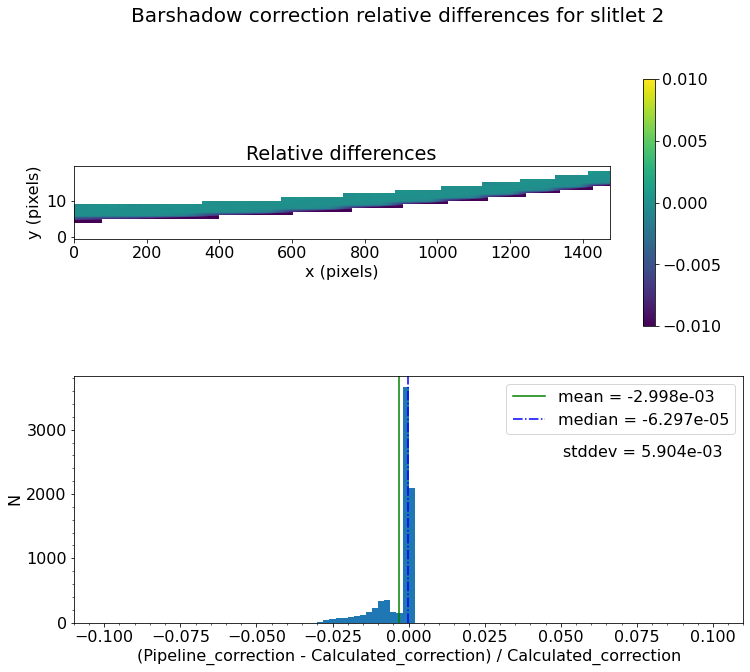


   Relative barshadow_correction  :   mean = -2.998e-03    median = -6.297e-05    stdev = 5.904e-03
    Maximum   Relativebarshadow_correction = 1.782e-03
    Minimum   Relativebarshadow_correction = -2.922e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 2? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  3
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibrations/

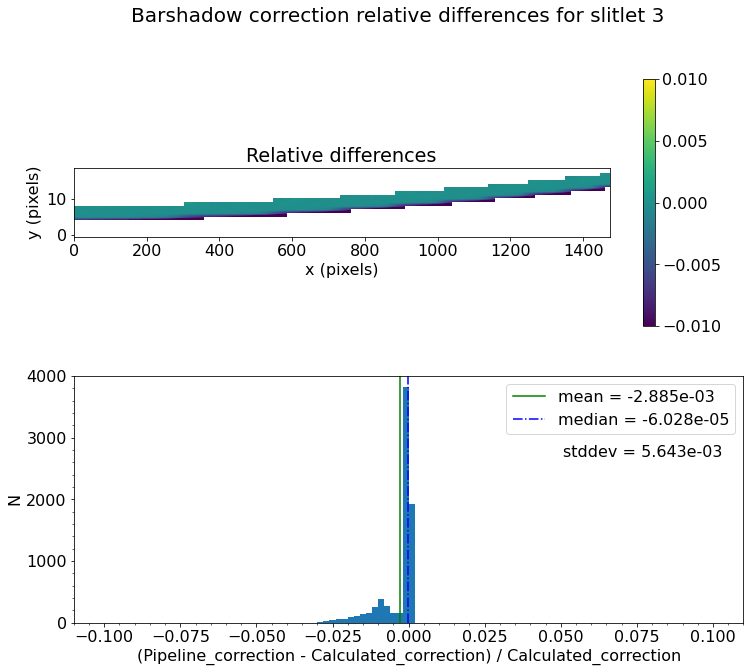


   Relative barshadow_correction  :   mean = -2.885e-03    median = -6.028e-05    stdev = 5.643e-03
    Maximum   Relativebarshadow_correction = 1.703e-03
    Minimum   Relativebarshadow_correction = -2.868e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 19%
                            ->  5xtheshold = 8%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 3? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  4
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibrations/

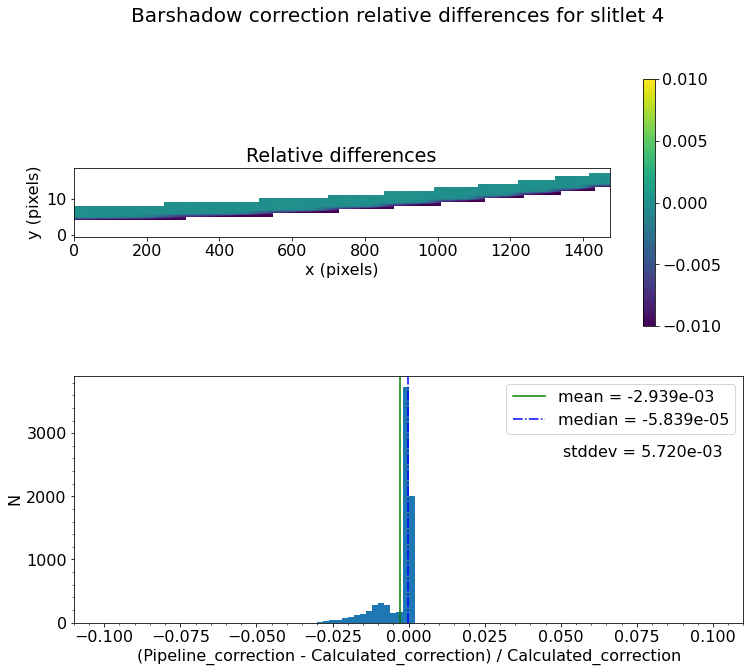


   Relative barshadow_correction  :   mean = -2.939e-03    median = -5.839e-05    stdev = 5.720e-03
    Maximum   Relativebarshadow_correction = 1.743e-03
    Minimum   Relativebarshadow_correction = -2.875e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 19%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 4? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  5
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibrations/

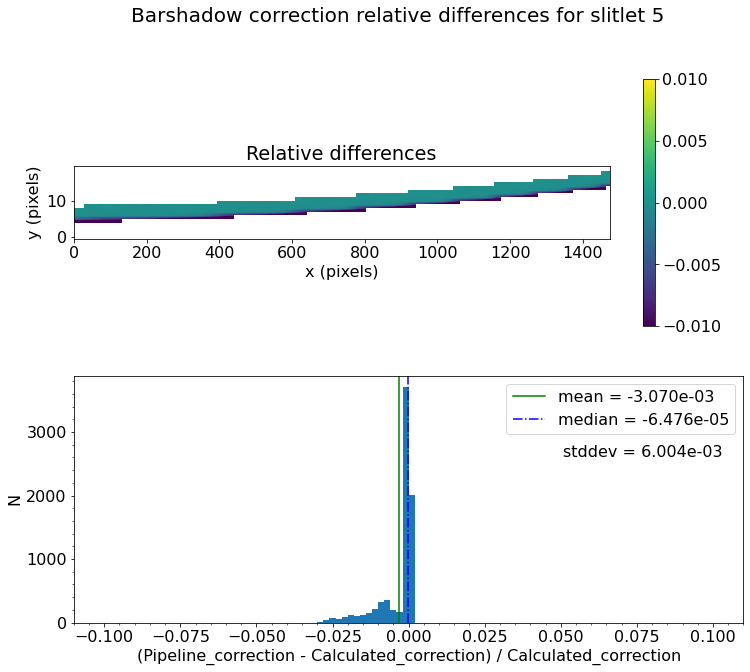


   Relative barshadow_correction  :   mean = -3.070e-03    median = -6.476e-05    stdev = 6.004e-03
    Maximum   Relativebarshadow_correction = 1.519e-03
    Minimum   Relativebarshadow_correction = -2.908e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 5? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  12
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibrations

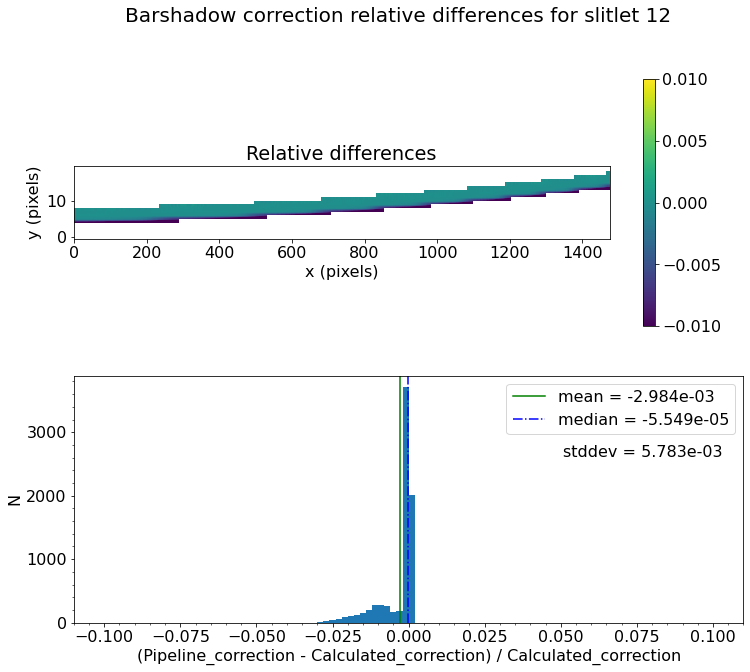


   Relative barshadow_correction  :   mean = -2.984e-03    median = -5.549e-05    stdev = 5.783e-03
    Maximum   Relativebarshadow_correction = 1.209e-03
    Minimum   Relativebarshadow_correction = -2.851e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 12? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  13
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

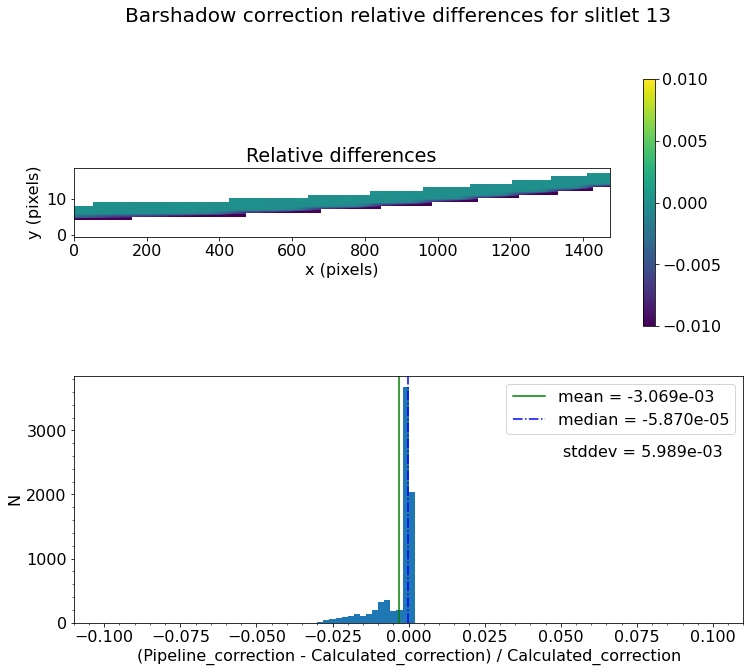


   Relative barshadow_correction  :   mean = -3.069e-03    median = -5.870e-05    stdev = 5.989e-03
    Maximum   Relativebarshadow_correction = 1.744e-03
    Minimum   Relativebarshadow_correction = -2.906e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 26%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 13? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  20
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

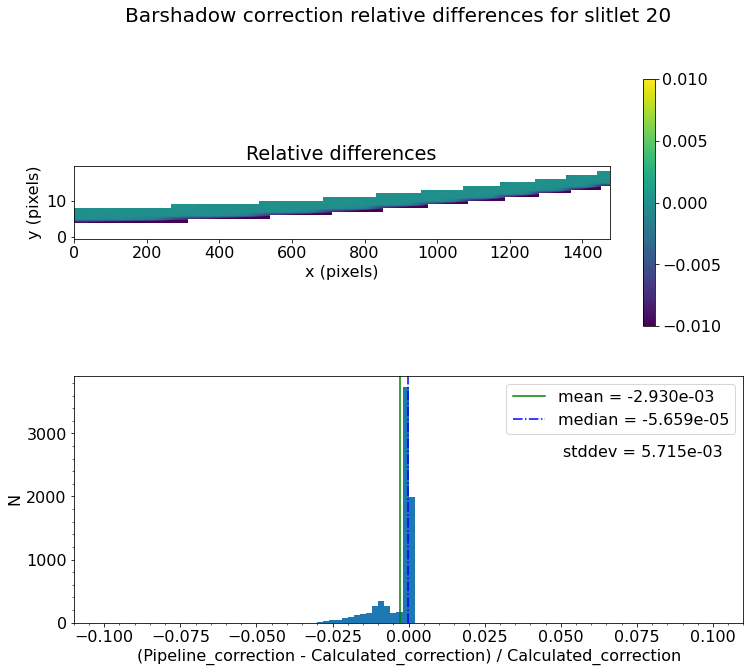


   Relative barshadow_correction  :   mean = -2.930e-03    median = -5.659e-05    stdev = 5.715e-03
    Maximum   Relativebarshadow_correction = 1.938e-03
    Minimum   Relativebarshadow_correction = -2.900e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 19%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 20? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  22
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

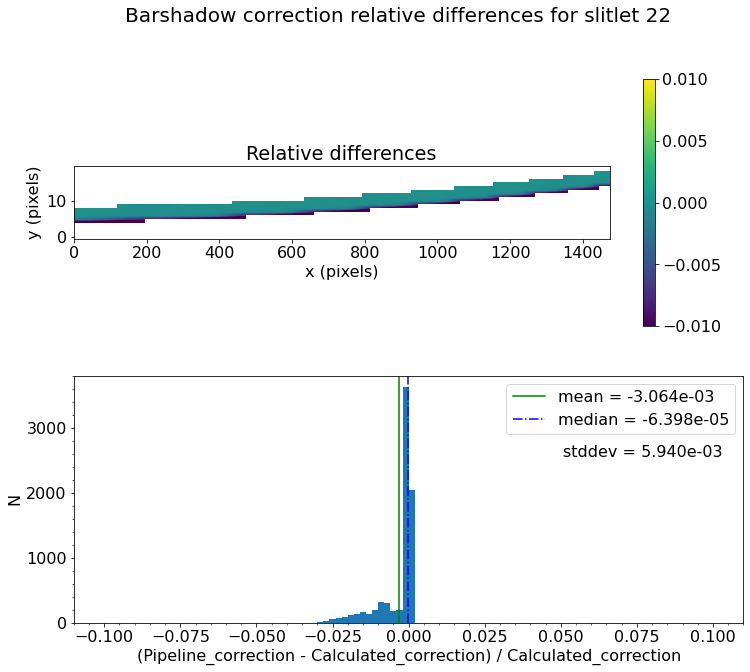


   Relative barshadow_correction  :   mean = -3.064e-03    median = -6.398e-05    stdev = 5.940e-03
    Maximum   Relativebarshadow_correction = 2.135e-03
    Minimum   Relativebarshadow_correction = -2.875e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 10%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 22? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  23
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibratio

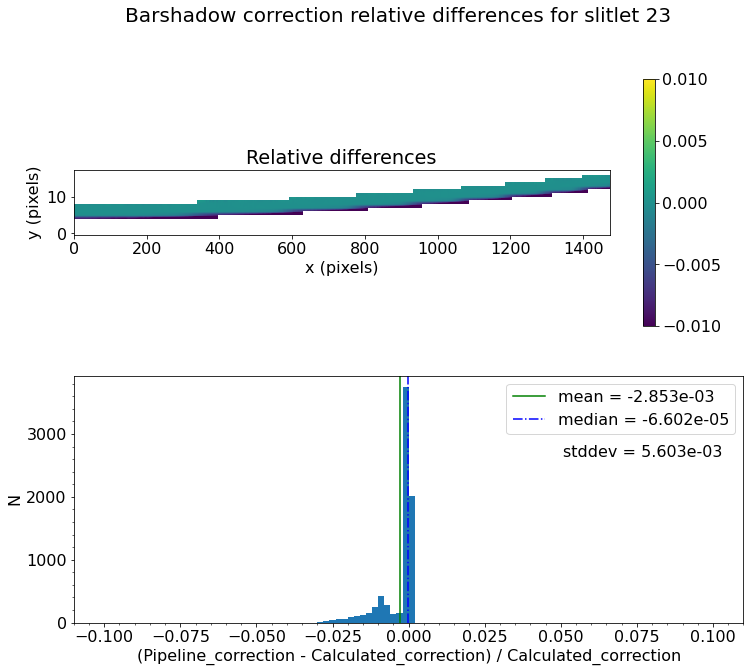


   Relative barshadow_correction  :   mean = -2.853e-03    median = -6.602e-05    stdev = 5.603e-03
    Maximum   Relativebarshadow_correction = 1.440e-03
    Minimum   Relativebarshadow_correction = -2.852e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 19%
                            ->  5xtheshold = 8%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 23? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  24
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

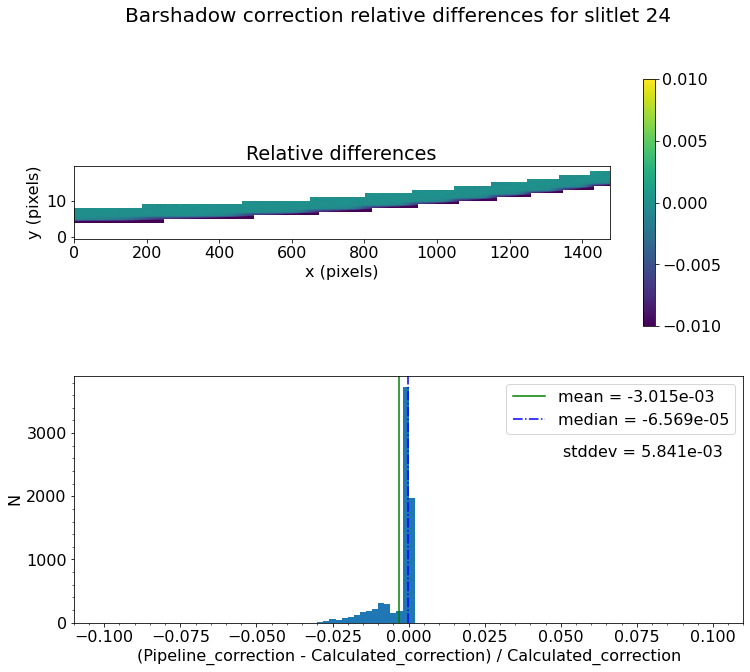


   Relative barshadow_correction  :   mean = -3.015e-03    median = -6.569e-05    stdev = 5.841e-03
    Maximum   Relativebarshadow_correction = 1.784e-03
    Minimum   Relativebarshadow_correction = -2.835e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 10%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 24? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  28
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibratio

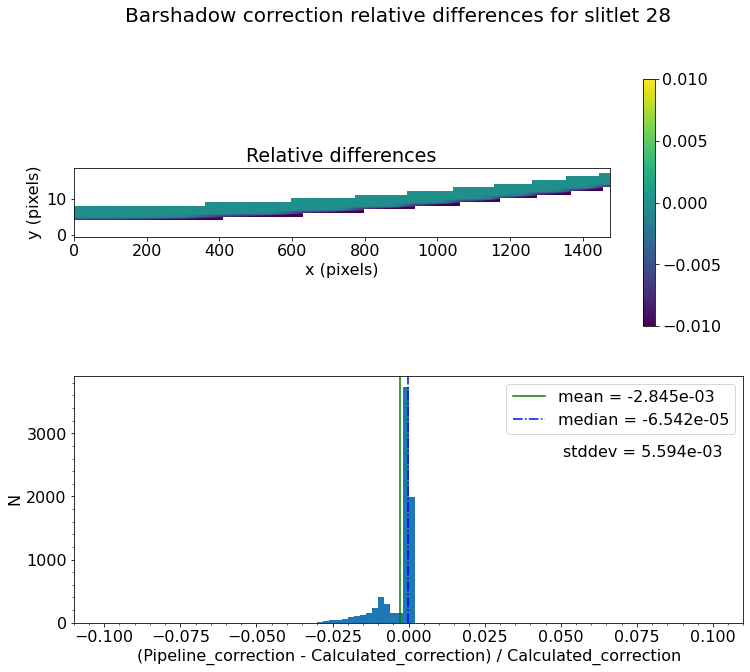


   Relative barshadow_correction  :   mean = -2.845e-03    median = -6.542e-05    stdev = 5.594e-03
    Maximum   Relativebarshadow_correction = 1.789e-03
    Minimum   Relativebarshadow_correction = -2.914e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 19%
                            ->  5xtheshold = 8%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 28? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  30
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

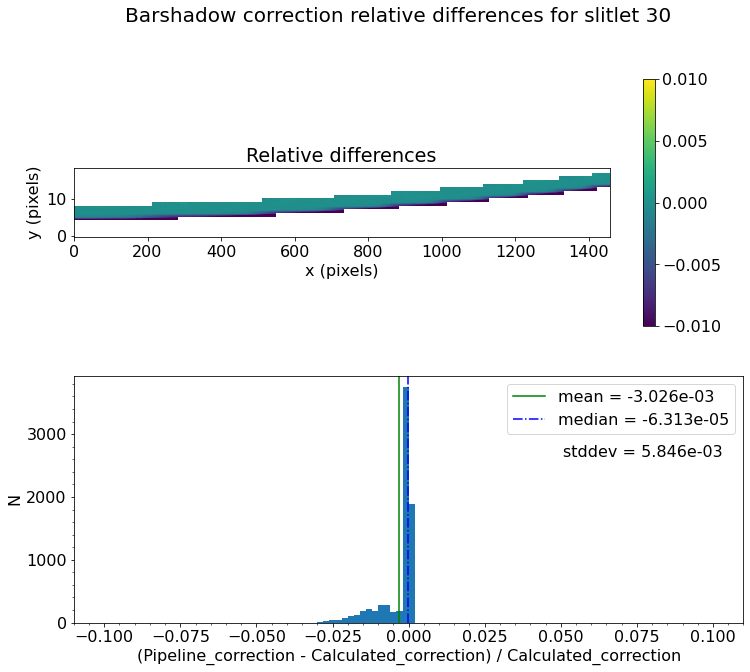


   Relative barshadow_correction  :   mean = -3.026e-03    median = -6.313e-05    stdev = 5.846e-03
    Maximum   Relativebarshadow_correction = 1.936e-03
    Minimum   Relativebarshadow_correction = -2.923e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 10%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 30? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  34
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibratio

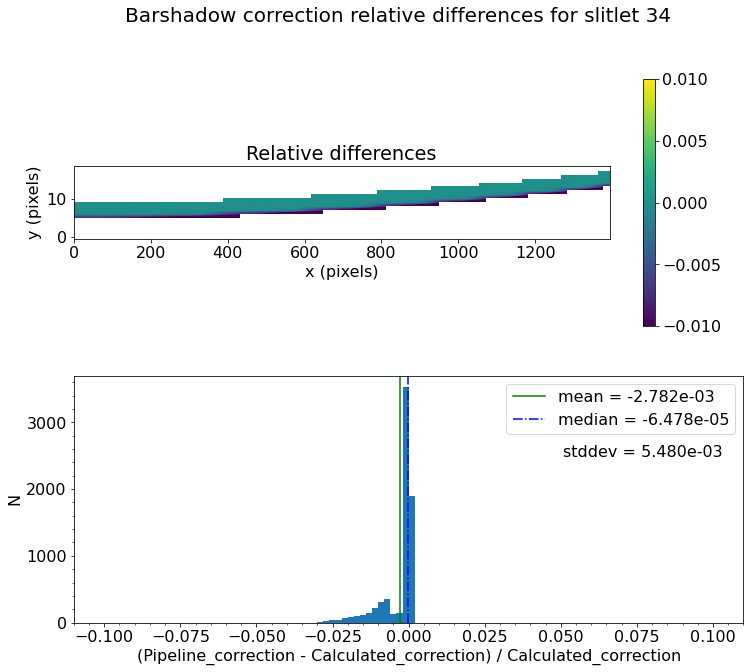


   Relative barshadow_correction  :   mean = -2.782e-03    median = -6.478e-05    stdev = 5.480e-03
    Maximum   Relativebarshadow_correction = 1.829e-03
    Minimum   Relativebarshadow_correction = -2.852e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 17%
                            ->  5xtheshold = 8%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 34? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  36
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

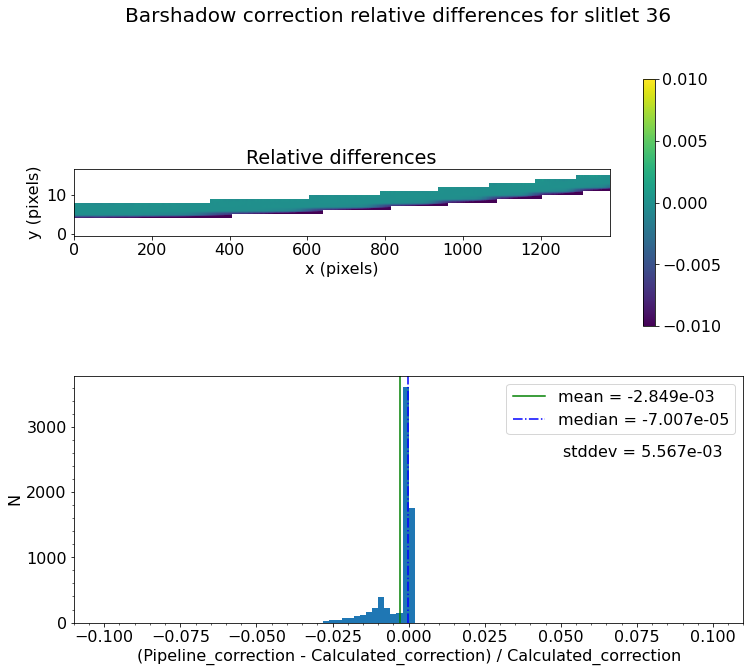


   Relative barshadow_correction  :   mean = -2.849e-03    median = -7.007e-05    stdev = 5.567e-03
    Maximum   Relativebarshadow_correction = 1.244e-03
    Minimum   Relativebarshadow_correction = -2.806e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 19%
                            ->  5xtheshold = 8%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 36? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  40
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

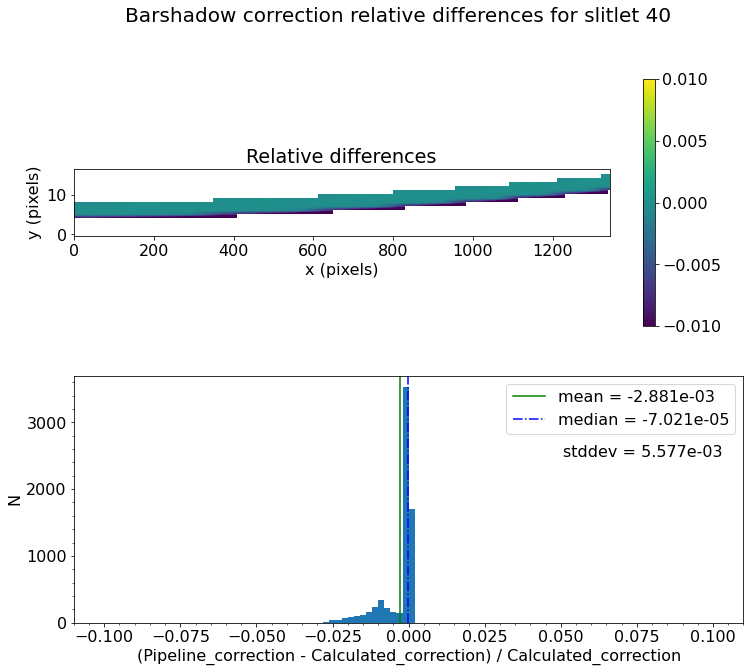


   Relative barshadow_correction  :   mean = -2.881e-03    median = -7.021e-05    stdev = 5.577e-03
    Maximum   Relativebarshadow_correction = 1.526e-03
    Minimum   Relativebarshadow_correction = -2.796e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 8%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 40? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  42
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

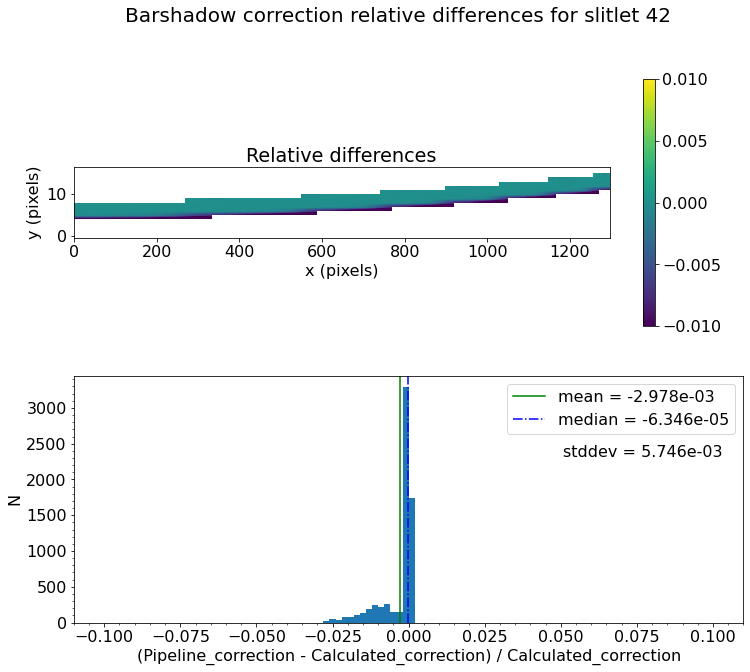


   Relative barshadow_correction  :   mean = -2.978e-03    median = -6.346e-05    stdev = 5.746e-03
    Maximum   Relativebarshadow_correction = 2.072e-03
    Minimum   Relativebarshadow_correction = -2.791e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 42? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  43
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

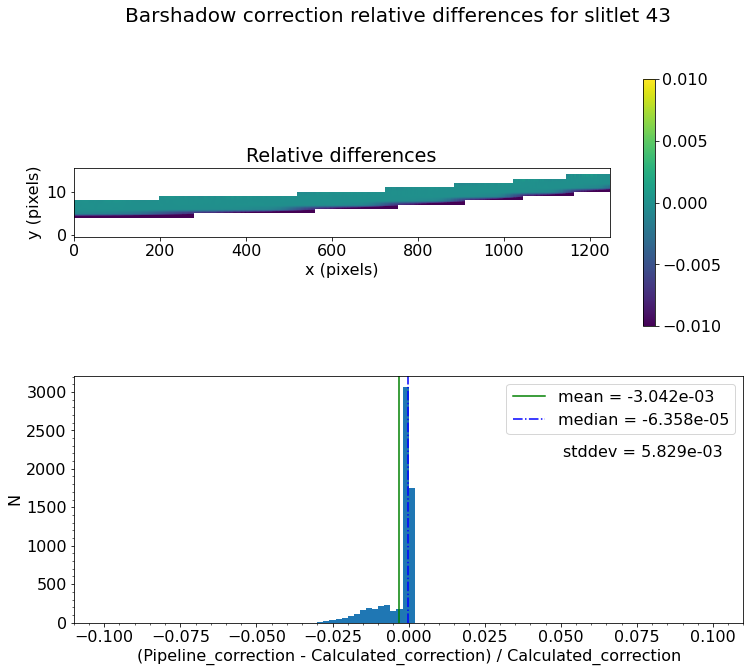


   Relative barshadow_correction  :   mean = -3.042e-03    median = -6.358e-05    stdev = 5.829e-03
    Maximum   Relativebarshadow_correction = 1.221e-03
    Minimum   Relativebarshadow_correction = -2.884e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 11%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 43? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: FAILED

Working with slitlet  44
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Referenc

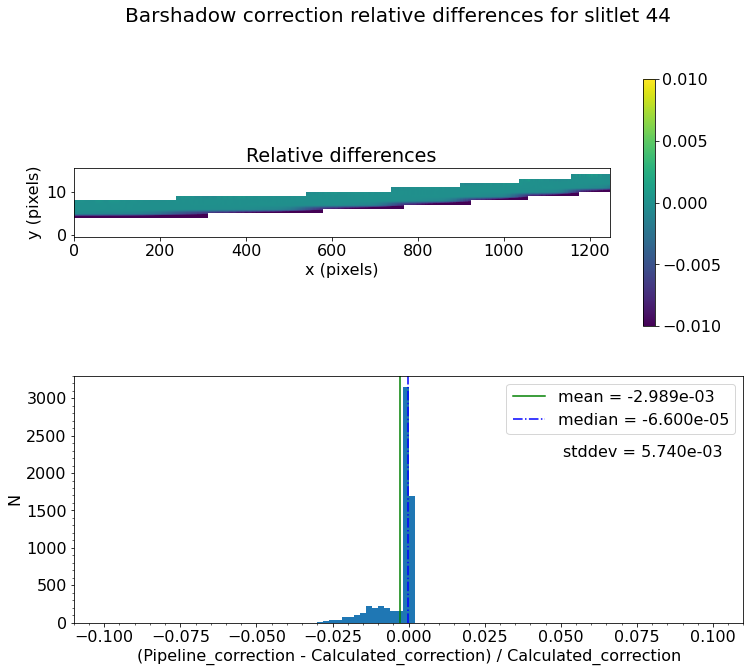

2021-02-20 01:48:20,305 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:48:20,306 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(




   Relative barshadow_correction  :   mean = -2.989e-03    median = -6.600e-05    stdev = 5.740e-03
    Maximum   Relativebarshadow_correction = 1.406e-03
    Minimum   Relativebarshadow_correction = -2.910e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 10%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 44? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  45
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibratio

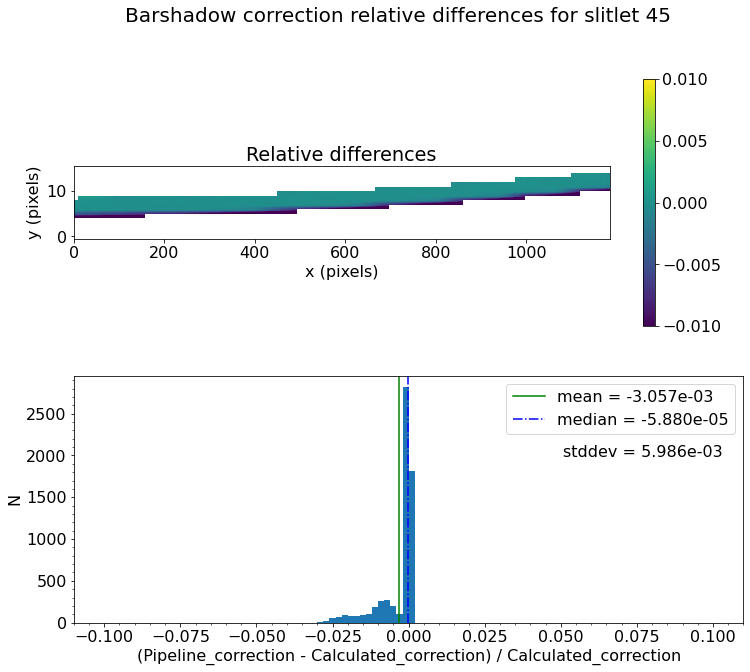

2021-02-20 01:48:22,139 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:48:22,140 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(

2021-02-20 01:48:22,208 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:48:22,209 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(




   Relative barshadow_correction  :   mean = -3.057e-03    median = -5.880e-05    stdev = 5.986e-03
    Maximum   Relativebarshadow_correction = 1.425e-03
    Minimum   Relativebarshadow_correction = -2.889e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 45? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  46
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

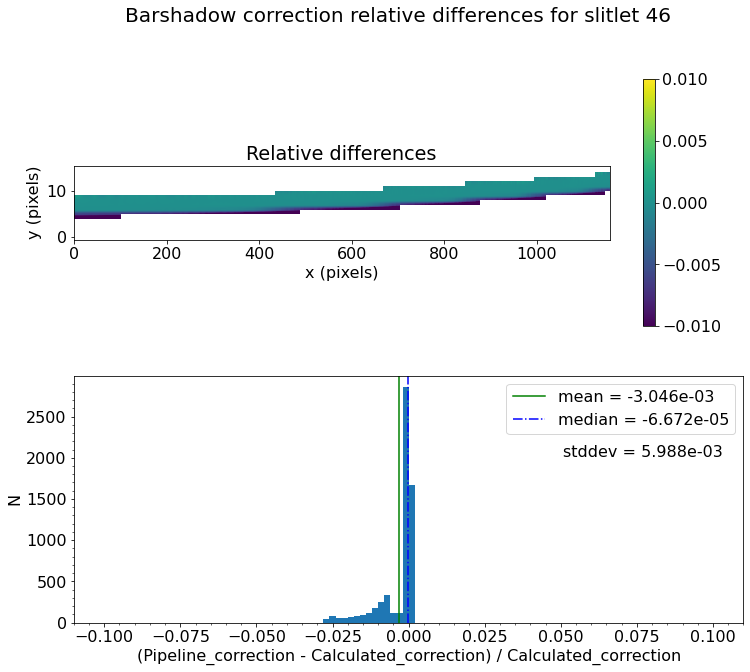

2021-02-20 01:48:24,025 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:48:24,026 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(

2021-02-20 01:48:24,095 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:48:24,096 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(




   Relative barshadow_correction  :   mean = -3.046e-03    median = -6.672e-05    stdev = 5.988e-03
    Maximum   Relativebarshadow_correction = 1.793e-03
    Minimum   Relativebarshadow_correction = -2.787e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 46? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  47
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

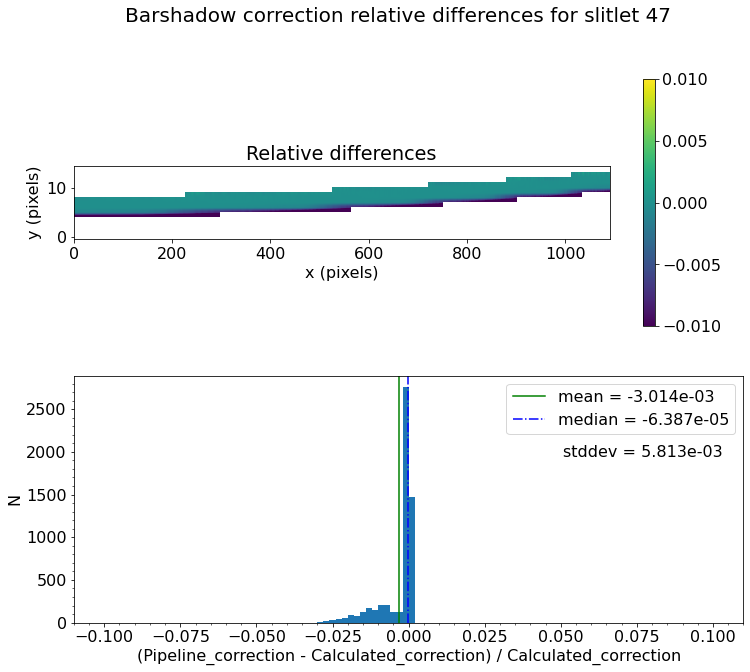

2021-02-20 01:48:25,862 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:48:25,862 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(

2021-02-20 01:48:25,931 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:48:25,931 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(




   Relative barshadow_correction  :   mean = -3.014e-03    median = -6.387e-05    stdev = 5.813e-03
    Maximum   Relativebarshadow_correction = 1.517e-03
    Minimum   Relativebarshadow_correction = -2.902e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 10%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 47? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  48
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibratio

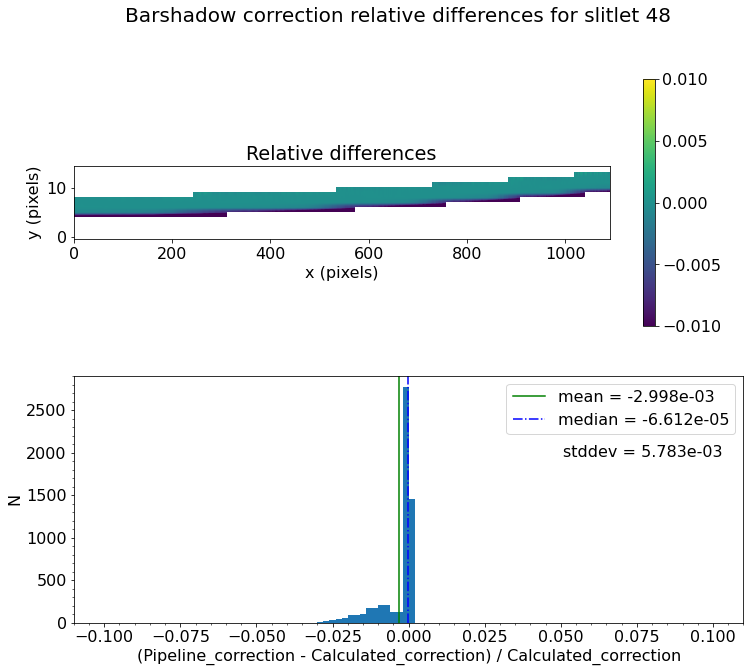

2021-02-20 01:48:27,711 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:48:27,712 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(

2021-02-20 01:48:27,780 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:48:27,780 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(




   Relative barshadow_correction  :   mean = -2.998e-03    median = -6.612e-05    stdev = 5.783e-03
    Maximum   Relativebarshadow_correction = 1.651e-03
    Minimum   Relativebarshadow_correction = -2.877e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 10%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 48? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  49
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibratio

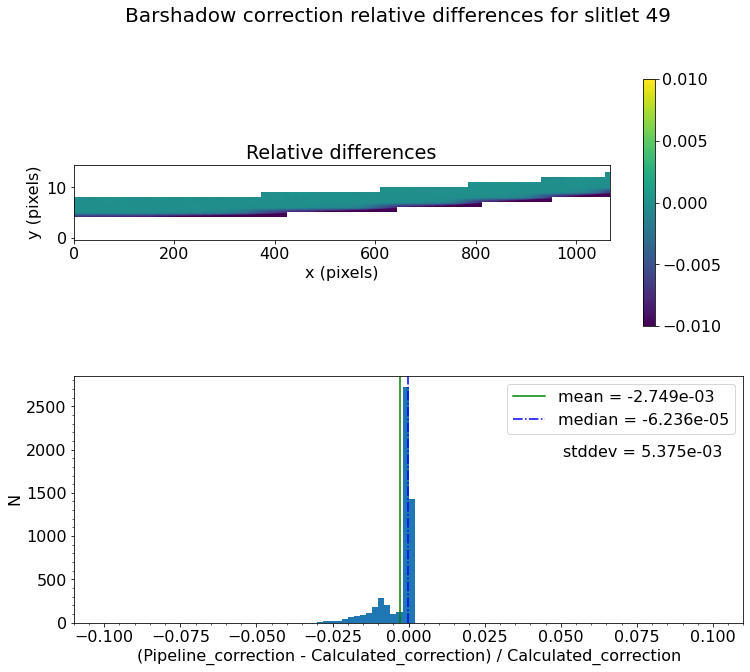

2021-02-20 01:48:29,570 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:48:29,571 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(

2021-02-20 01:48:29,637 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:48:29,637 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(




   Relative barshadow_correction  :   mean = -2.749e-03    median = -6.236e-05    stdev = 5.375e-03
    Maximum   Relativebarshadow_correction = 1.177e-03
    Minimum   Relativebarshadow_correction = -2.815e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 19%
                            ->  5xtheshold = 8%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 49? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  50
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

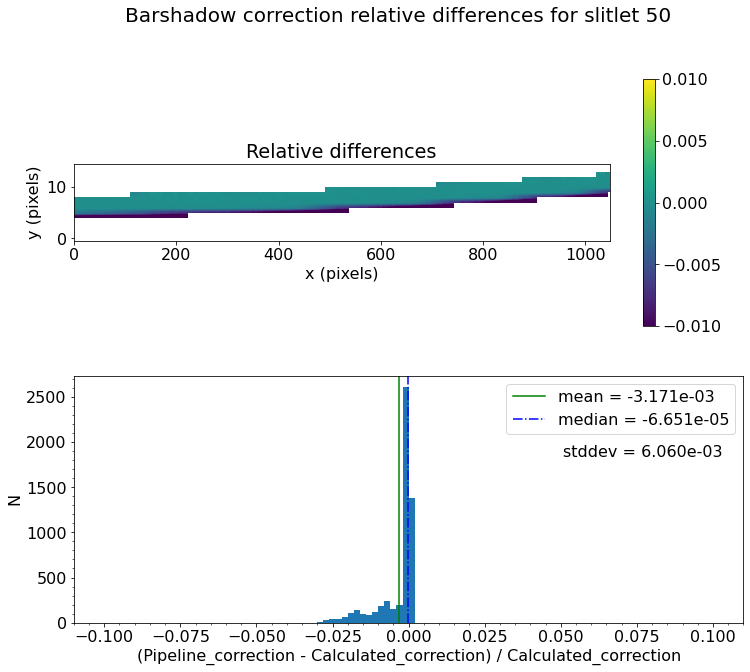

2021-02-20 01:48:31,437 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:48:31,438 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(

2021-02-20 01:48:31,507 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:48:31,508 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(




   Relative barshadow_correction  :   mean = -3.171e-03    median = -6.651e-05    stdev = 6.060e-03
    Maximum   Relativebarshadow_correction = 1.648e-03
    Minimum   Relativebarshadow_correction = -2.837e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 26%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 11%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 50? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: FAILED

Working with slitlet  51
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Referenc

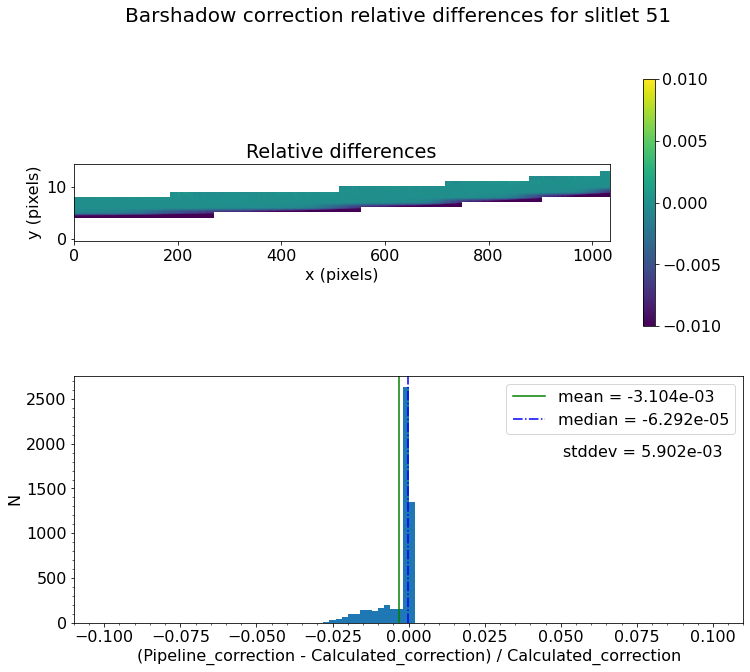

2021-02-20 01:48:34,264 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:48:34,264 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(

2021-02-20 01:48:34,334 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:48:34,335 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(




   Relative barshadow_correction  :   mean = -3.104e-03    median = -6.292e-05    stdev = 5.902e-03
    Maximum   Relativebarshadow_correction = 1.358e-03
    Minimum   Relativebarshadow_correction = -2.734e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 11%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 51? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: FAILED

Working with slitlet  52
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Referenc

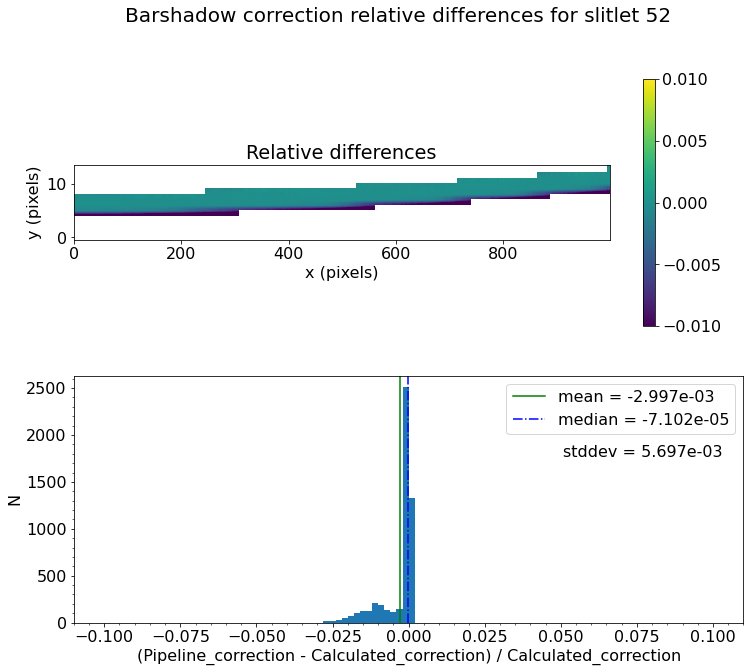

2021-02-20 01:48:36,174 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:48:36,175 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(

2021-02-20 01:48:36,238 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:48:36,239 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(

2021-02-20 01:48:36,240 - stpipe -


   Relative barshadow_correction  :   mean = -2.997e-03    median = -7.102e-05    stdev = 5.697e-03
    Maximum   Relativebarshadow_correction = 1.044e-03
    Minimum   Relativebarshadow_correction = -2.715e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 19%
                            ->  5xtheshold = 10%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 52? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  55
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibratio

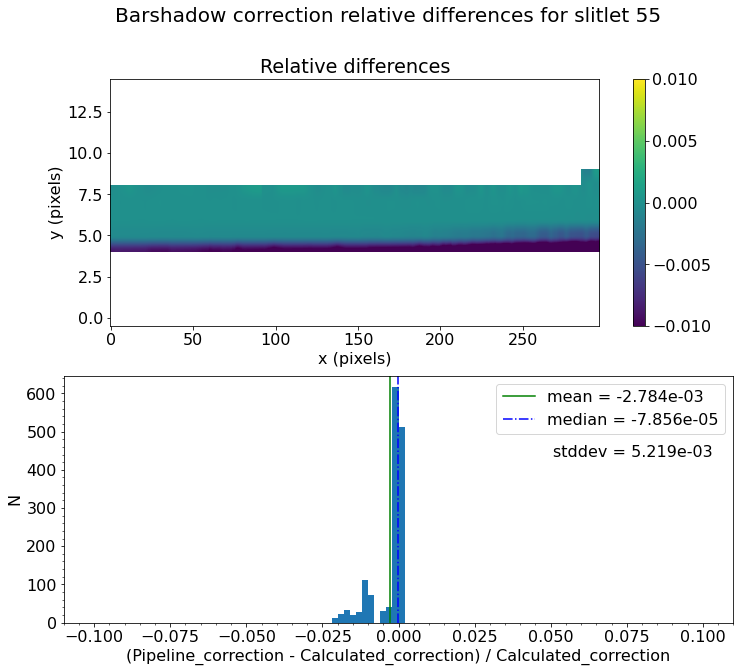

2021-02-20 01:48:38,077 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:48:38,078 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(

2021-02-20 01:48:38,080 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:48:38,081 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(

2021-02-20 01:48:38,148 - stpipe -


   Relative barshadow_correction  :   mean = -2.784e-03    median = -7.856e-05    stdev = 5.219e-03
    Maximum   Relativebarshadow_correction = 1.028e-03
    Minimum   Relativebarshadow_correction = -2.143e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 20%
                            ->  5xtheshold = 7%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 55? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  56
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

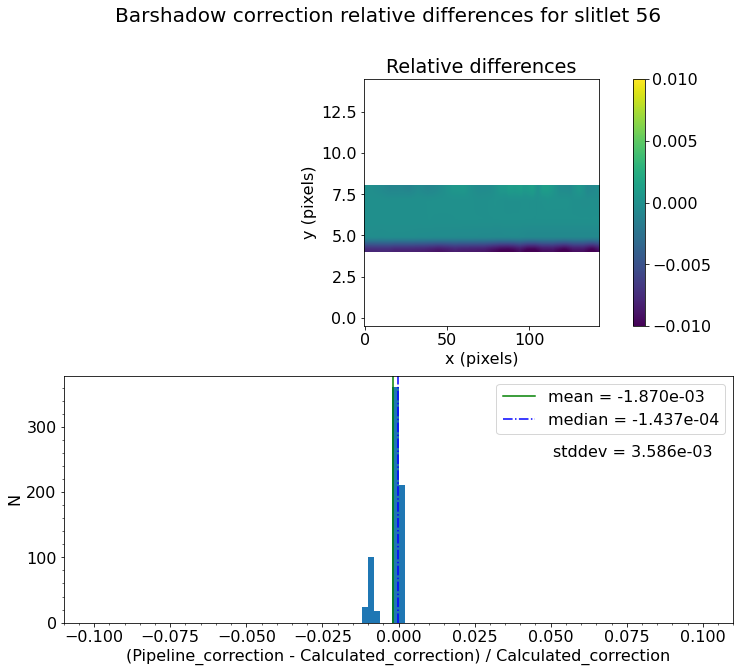

2021-02-20 01:48:39,856 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:48:39,857 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(

2021-02-20 01:48:39,858 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:48:39,859 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(

2021-02-20 01:48:39,929 - stpipe -


   Relative barshadow_correction  :   mean = -1.870e-03    median = -1.437e-04    stdev = 3.586e-03
    Maximum   Relativebarshadow_correction = 1.258e-03
    Minimum   Relativebarshadow_correction = -1.043e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 20%
                            ->  3xtheshold = 20%
                            ->  5xtheshold = 0%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 56? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  57
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

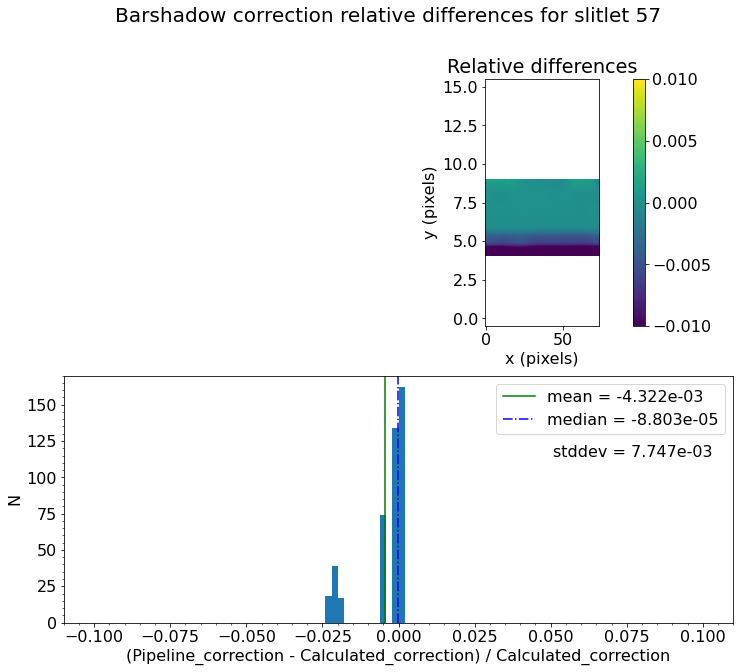

2021-02-20 01:48:41,671 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:48:41,672 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(

2021-02-20 01:48:41,673 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2021-02-20 01:48:41,674 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(




   Relative barshadow_correction  :   mean = -4.322e-03    median = -8.803e-05    stdev = 7.747e-03
    Maximum   Relativebarshadow_correction = 1.475e-03
    Minimum   Relativebarshadow_correction = -2.267e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 33%
                            ->  3xtheshold = 17%
                            ->  5xtheshold = 17%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 57? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: FAILED


 * The test of barshadow_correction for slitlet 6  PASSED.

 * The test of barshadow_correction for slitlet 7  PASSED.

 * The test of barshadow_correction for

In [11]:
# Set common NPTT switches for this test

# accepted threshold difference with respect to benchmark files
barshadow_threshold_diff = 0.0025

# other variables
mode_used = 'MOS'
write_barshadow_files = False
show_final_fig = True
save_final_fig = False
show_intermediary_figs = False
save_intermediary_figs = False

# Get the data
results_dict = {}
detectors = ['nrs1', 'nrs2']
for mode_config, data_set_dict in testing_data.items():
    for det in detectors:
        print('Testing files for detector: ', det)
        data = get_artifactory_file(data_set_dict, det)
        uncal_file, msa_shutter_config = data
        print('Working with uncal_file: ', uncal_file)
        uncal_basename = os.path.basename(uncal_file)
        
        # Make sure there is a local copy of the MSA shutter configuration file
        if msa_shutter_config is not None:
            subprocess.run(['cp', msa_shutter_config , '.'])
        
        # Run the stage 1 pipeline 
        rate_object = Detector1Pipeline.call(uncal_file)
        # Make sure the MSA shutter configuration file is set up correctly
        if msa_shutter_config is not None:
            msa_metadata = rate_object.meta.instrument.msa_metadata_file
            if msa_metadata is None or msa_metadata == 'N/A':
                rate_object.meta.instrument.msa_metadata_file = msa_shutter_config

        # Run the stage 2 pipeline steps
        try:
            pipe_object = AssignWcsStep.call(rate_object)
        except:
            print('No open slits fall on detector ', det, '\n')
            continue
        pipe_object = MSAFlagOpenStep.call(pipe_object)
        pipe_object = Extract2dStep.call(pipe_object)
        pipe_object = SourceTypeStep.call(pipe_object)
        pipe_object = FlatFieldStep.call(pipe_object, save_interpolated_flat=False)
        pathloss_object = PathLossStep.call(pipe_object)
        barshadow_object = BarShadowStep.call(pathloss_object)

        # Run the validation test
        %matplotlib inline
        
        _, result_msg, _ = nptt.calwebb_spec2_pytests.auxiliary_code.barshadow_testing.run_barshadow_tests(
                                                            pathloss_object, 
                                                            barshadow_object,
                                                            barshadow_threshold_diff=barshadow_threshold_diff,
                                                            save_final_figs=save_final_fig,
                                                            show_final_figs=show_final_fig,
                                                            save_intermediary_figs=save_intermediary_figs,
                                                            show_intermediary_figs=show_intermediary_figs,
                                                            write_barshadow_files=write_barshadow_files)

        # Remove fits files from the repo directory
        local_fits_files = glob('./*.fits')
        for fits_file in local_fits_files:
            try:
                subprocess.run(['rm', fits_file])
            except FileNotFound:
                print('Fits file does not exist in current working directory: ', fits_file)

        # Did the test passed 
        print("Did barshadow validation test passed? ", result_msg, "\n\n")
        rd = {mode_config: result_msg}
        results_dict.update(rd)
        
        # close all open files
        psutil.Process().open_files()
        closing_files = []
        for fd in psutil.Process().open_files():
            if data_dir.name in fd.path:
                closing_files.append(fd)
        for fd in closing_files:
            open(fd.fd).close()
        
            

In [12]:
# Quickly see if the test passed 

print('These are the final results of the tests: ')
for key, val in results_dict.items():
    print(key, val)

2021-02-20 01:53:13,952 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



These are the final results of the tests: 
mos_prism_clear The test is skipped for POINT sources, since the correction is not applied
mos_g140m_f100lp 
 *** Final result for barshadow test will be reported as PASSED *** 



<a id="about_ID"></a>
## About this Notebook
**Author:** Maria A. Pena-Guerrero, Staff Scientist II - Systems Science Support, NIRSpec
<br>**Updated On:** Jan/22/2021

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 